In [1]:
import glob
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'iterations': [100, 200, 300, 400, 500], # Tương đương n_estimators
    'depth': [4, 6, 8, 9, 10],          # Tương đương max_depth, CatBoost thường dùng depth nhỏ hơn RF
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 7, 9], # L2 regularization
    'border_count': [32, 64, 128],   # Số lượng split cho các feature số
    'rsm': [0.7, 0.8, 0.9],
}

In [4]:
def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = CatBoostClassifier(random_seed=random_state, verbose=0)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro',
                refit=True
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = CatBoostClassifier(**best_params, random_seed=random_state, verbose=0)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    feature_importances = pd.Series(best_model.get_feature_importance(), index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics



======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'rsm': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 10, 'border_count': 32}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.84      1785
           1       0.66      0.35      0.46       604
           2       0.53      0.36      0.43       258
           3       0.38      0.20      0.26        59
           4       0.20      0.11      0.14         9

    accuracy                           0.73      2715
   macro avg       0.51      0.39      0.43      2715
weighted avg       0.71      0.73      0.70      2715



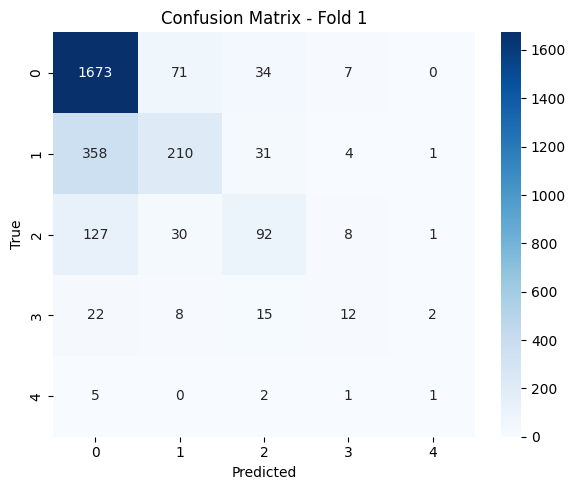

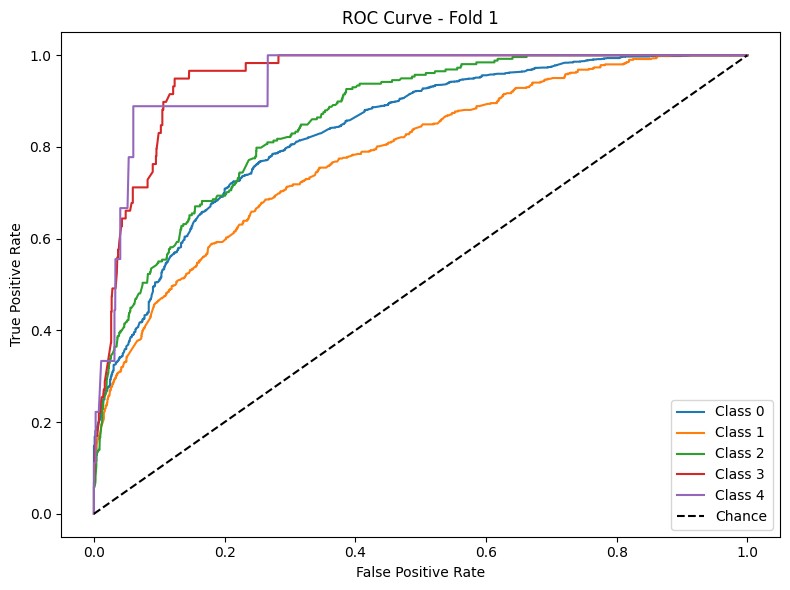


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1786
           1       0.55      0.33      0.42       603
           2       0.53      0.36      0.43       258
           3       0.38      0.15      0.22        59
           4       0.33      0.12      0.18         8

    accuracy                           0.71      2714
   macro avg       0.51      0.38      0.41      2714
weighted avg       0.68      0.71      0.68      2714



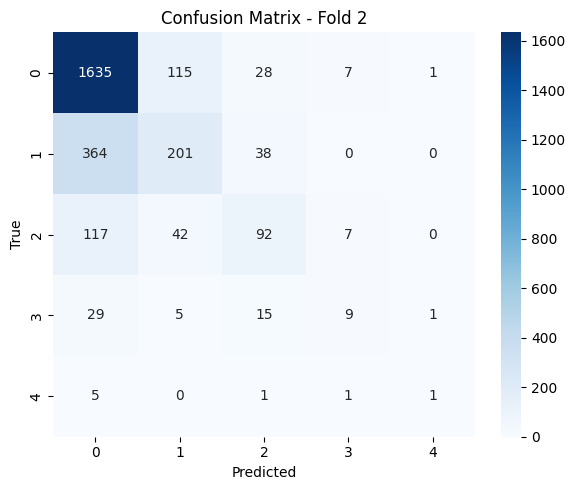

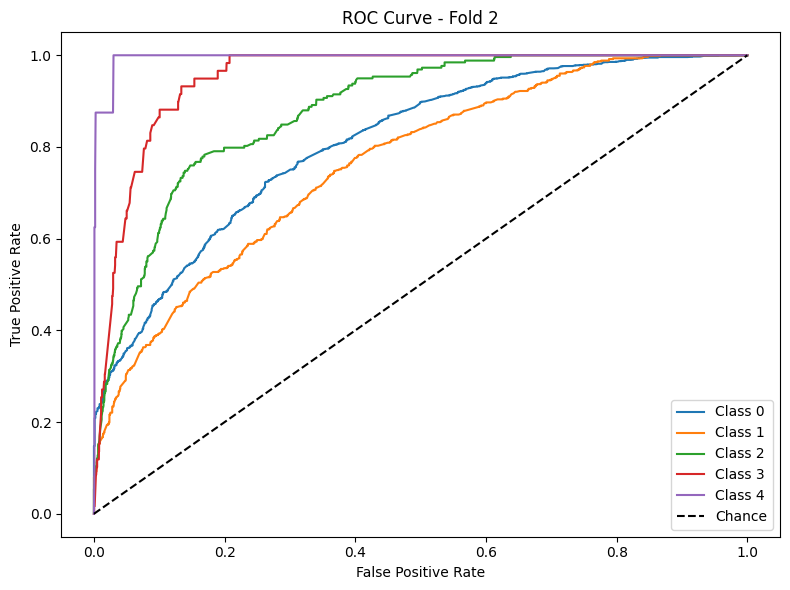


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1786
           1       0.60      0.34      0.43       603
           2       0.48      0.38      0.42       258
           3       0.53      0.29      0.37        59
           4       0.38      0.38      0.38         8

    accuracy                           0.72      2714
   macro avg       0.55      0.46      0.49      2714
weighted avg       0.70      0.72      0.70      2714



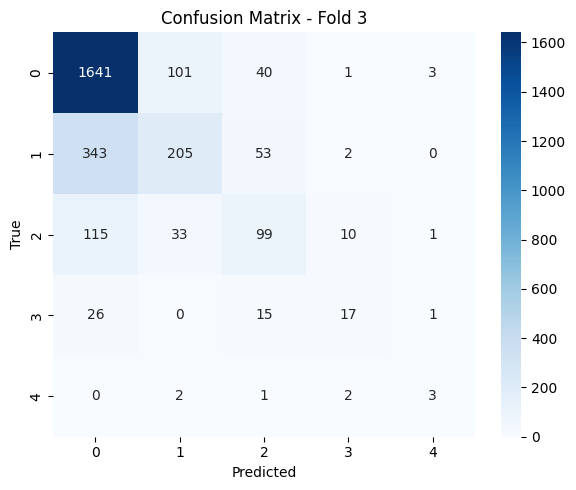

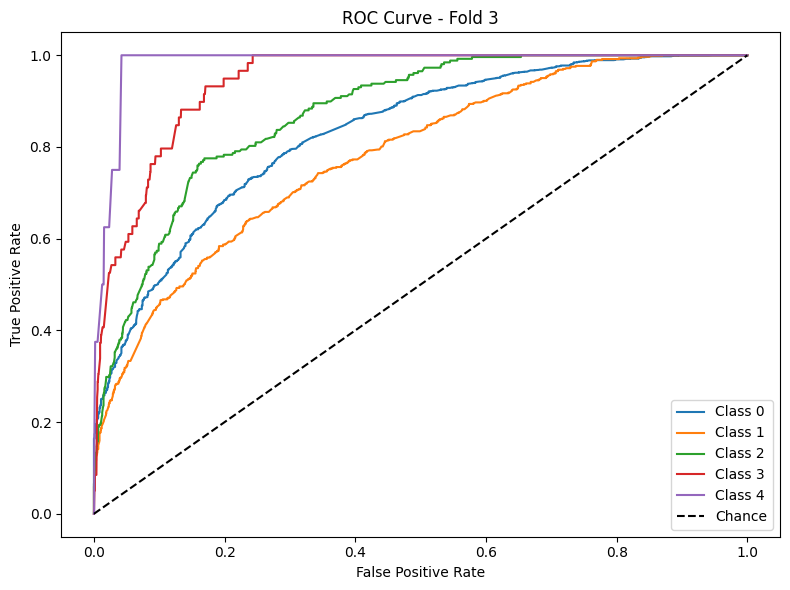


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1785
           1       0.64      0.37      0.47       603
           2       0.57      0.38      0.46       258
           3       0.29      0.15      0.20        59
           4       1.00      0.11      0.20         9

    accuracy                           0.73      2714
   macro avg       0.65      0.39      0.43      2714
weighted avg       0.71      0.73      0.71      2714



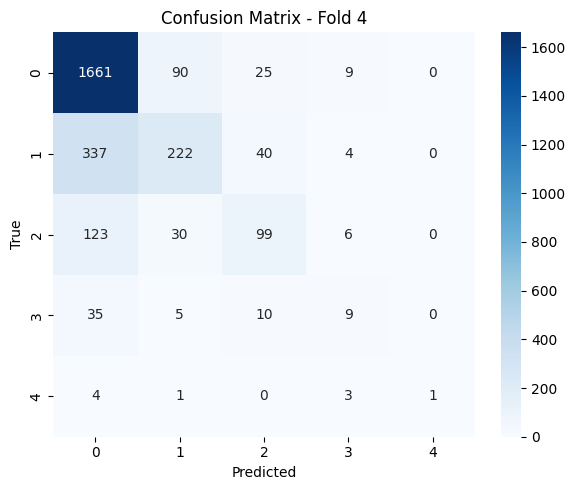

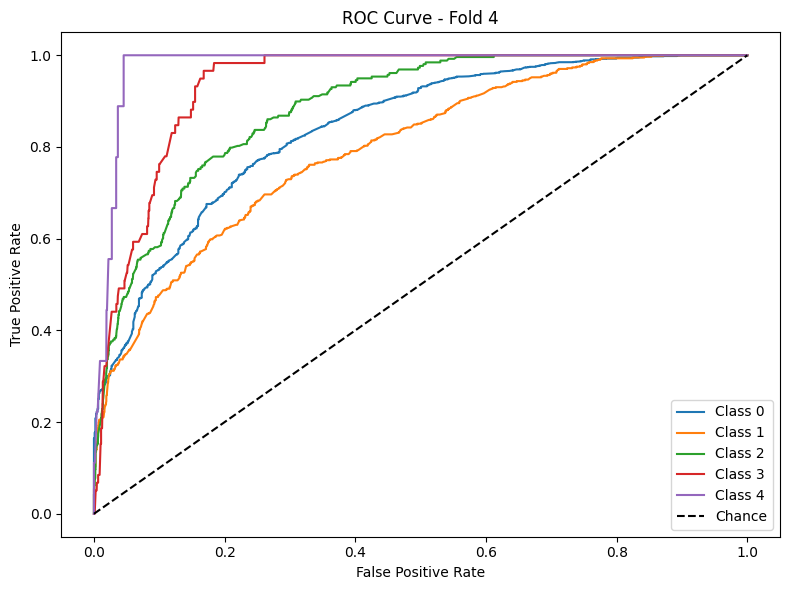


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1785
           1       0.60      0.36      0.45       603
           2       0.56      0.37      0.45       258
           3       0.40      0.17      0.24        59
           4       1.00      0.11      0.20         9

    accuracy                           0.73      2714
   macro avg       0.67      0.39      0.44      2714
weighted avg       0.71      0.73      0.70      2714



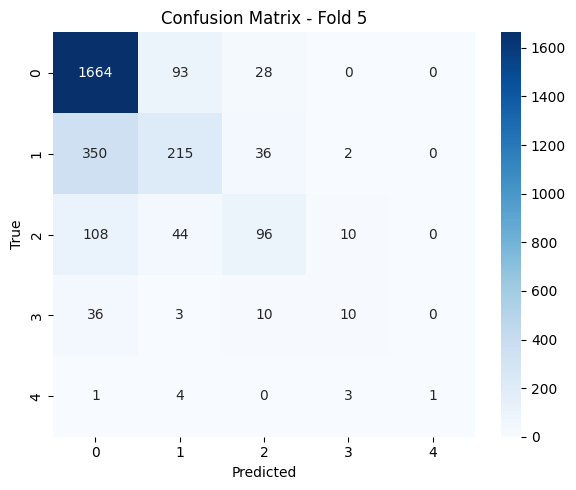

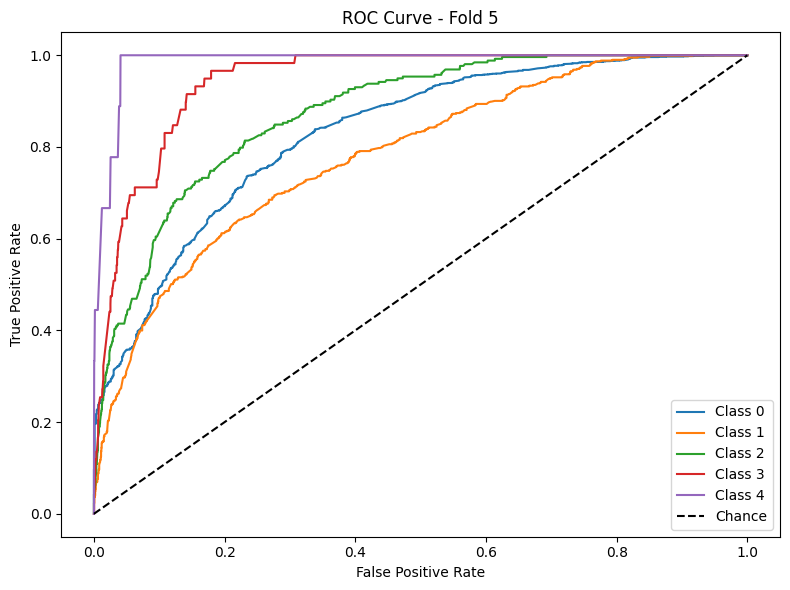


Average Accuracy: 0.7272
Average F1 Macro: 0.4397
Average AUC: 0.8815

Feature Importances:
video                                  11.529089
remaining_time                         10.896975
school                                  9.038742
video_count                             8.235931
exercise_count                          8.119684
assignment                              7.428938
encoded_field_sum                       6.585159
duration_days                           6.095492
user_month                              5.704414
chapter_count                           4.675219
total_words_phase1                      3.473109
num_prerequisites                       2.841579
total_neutral1                          2.495706
entropy_time_comment_phase1             1.396597
exercise_perc_real_score_mean_1         1.370990
certificate                             1.318186
user_past_course_count                  1.296318
exercise_correct_sum_1                  1.128010
total_positive1          

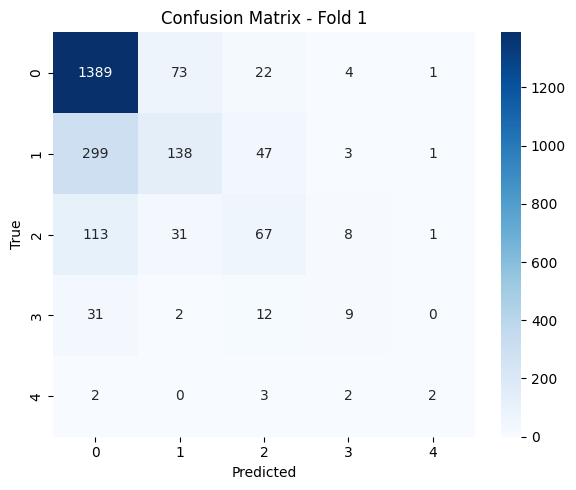

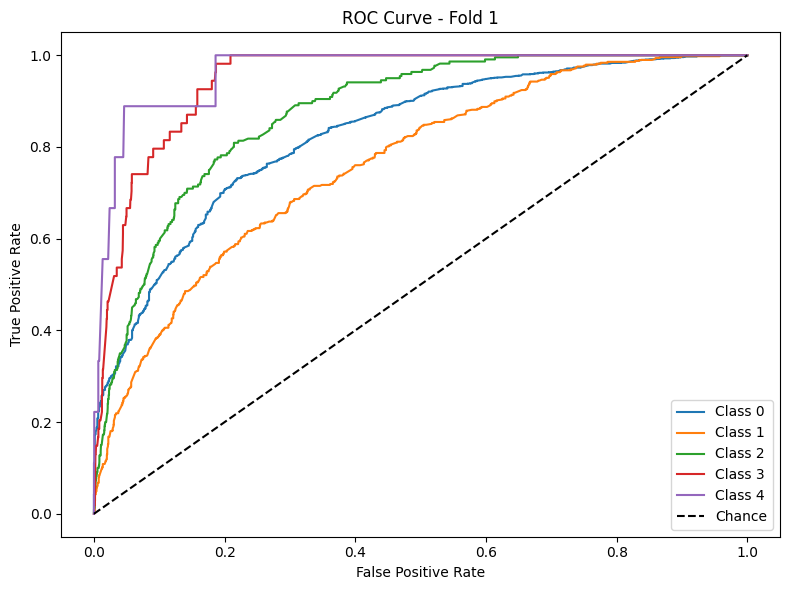

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.83      1489
           1       0.58      0.27      0.37       489
           2       0.44      0.35      0.39       219
           3       0.26      0.18      0.22        55
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2260
   macro avg       0.41      0.34      0.36      2260
weighted avg       0.67      0.71      0.67      2260



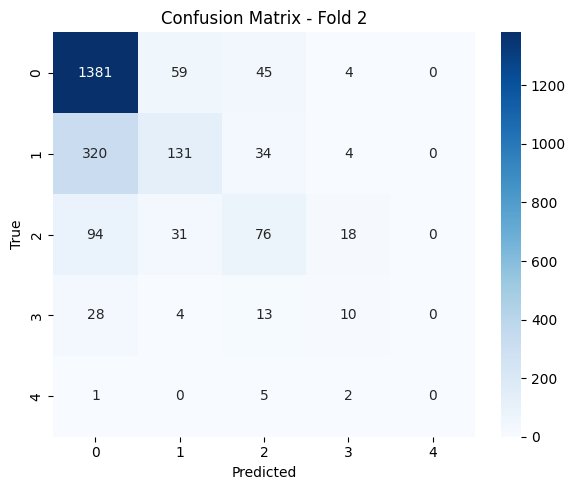

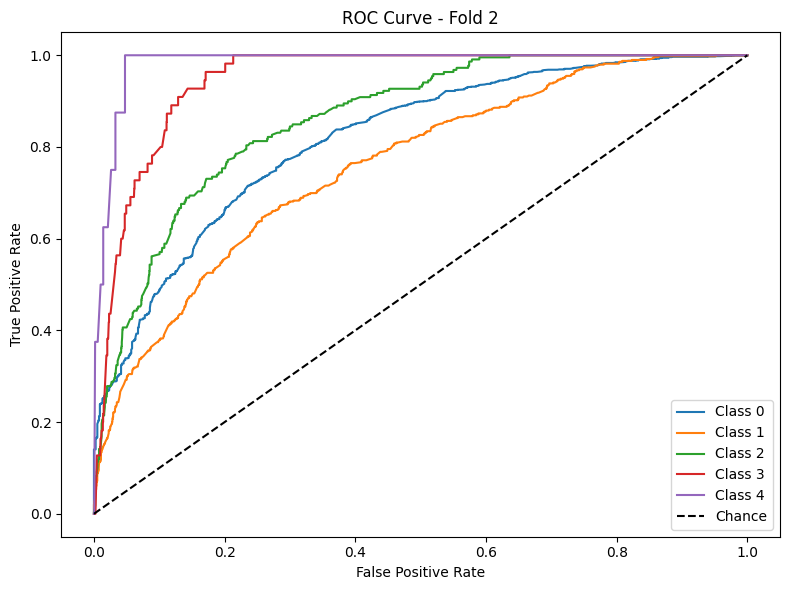


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84      1489
           1       0.58      0.26      0.36       489
           2       0.49      0.35      0.41       219
           3       0.32      0.22      0.26        54
           4       1.00      0.12      0.22         8

    accuracy                           0.71      2259
   macro avg       0.63      0.38      0.42      2259
weighted avg       0.68      0.71      0.68      2259



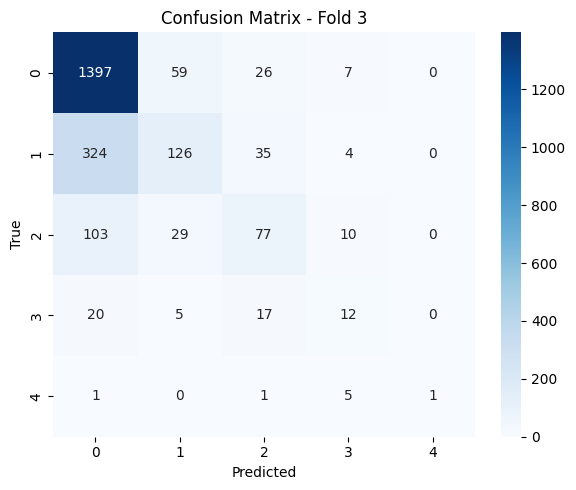

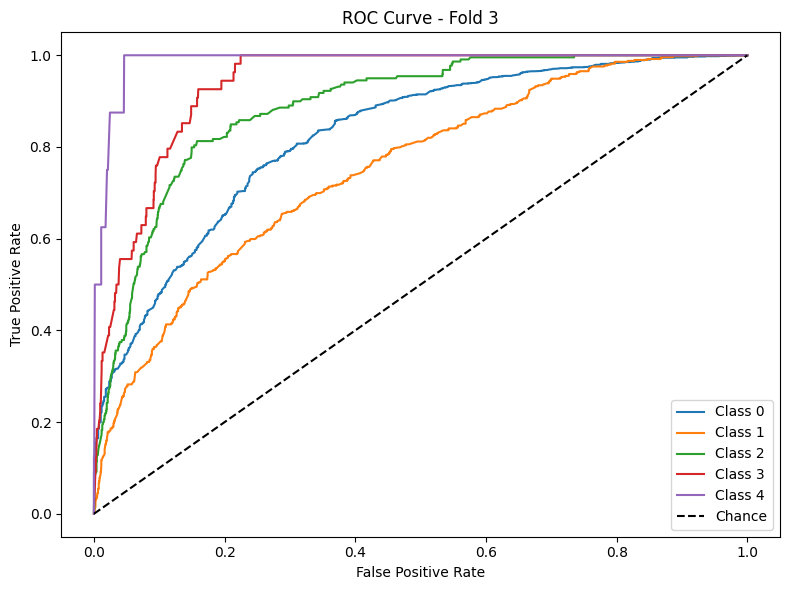


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.93      0.83      1489
           1       0.60      0.28      0.38       489
           2       0.53      0.37      0.44       219
           3       0.40      0.19      0.25        54
           4       0.60      0.38      0.46         8

    accuracy                           0.72      2259
   macro avg       0.58      0.43      0.47      2259
weighted avg       0.69      0.72      0.68      2259



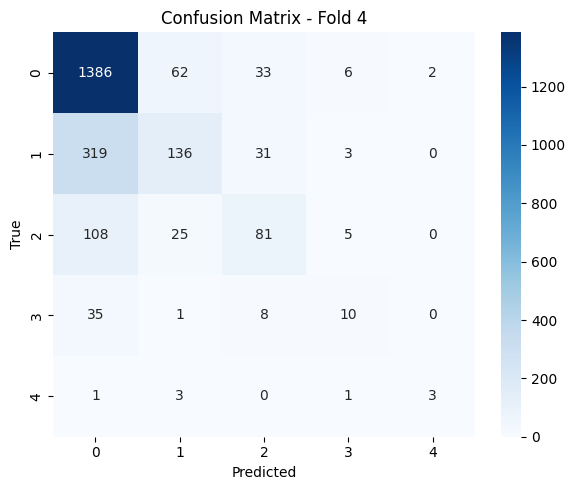

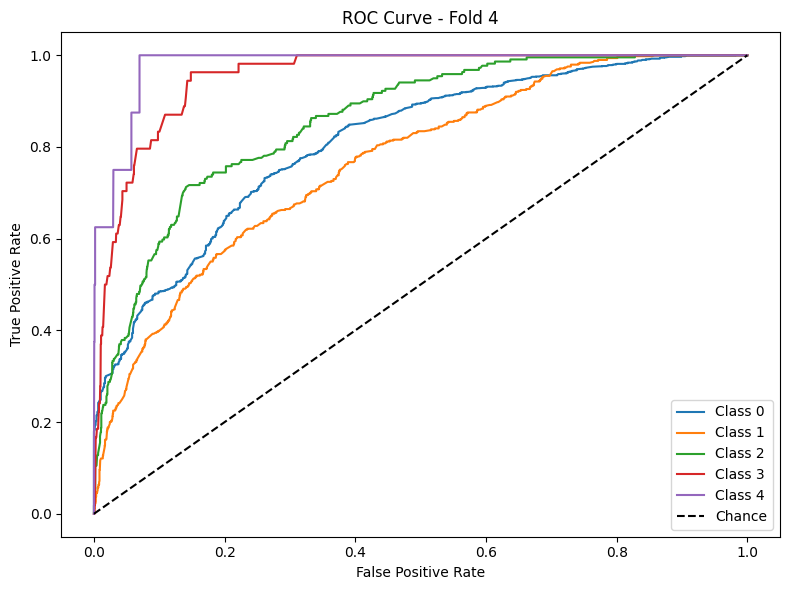


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1490
           1       0.60      0.34      0.44       488
           2       0.50      0.38      0.43       219
           3       0.32      0.15      0.20        54
           4       0.25      0.12      0.17         8

    accuracy                           0.73      2259
   macro avg       0.49      0.39      0.42      2259
weighted avg       0.70      0.73      0.70      2259



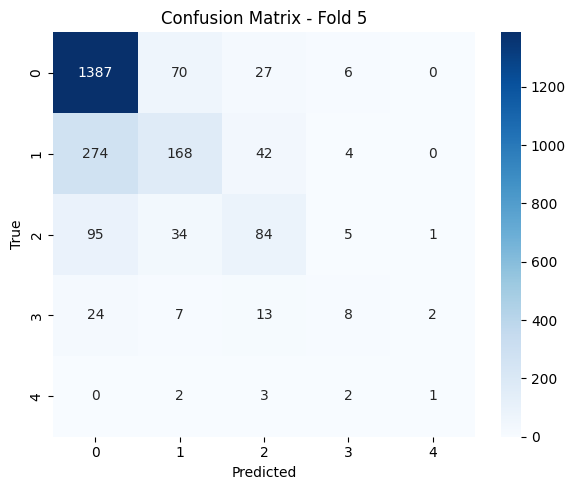

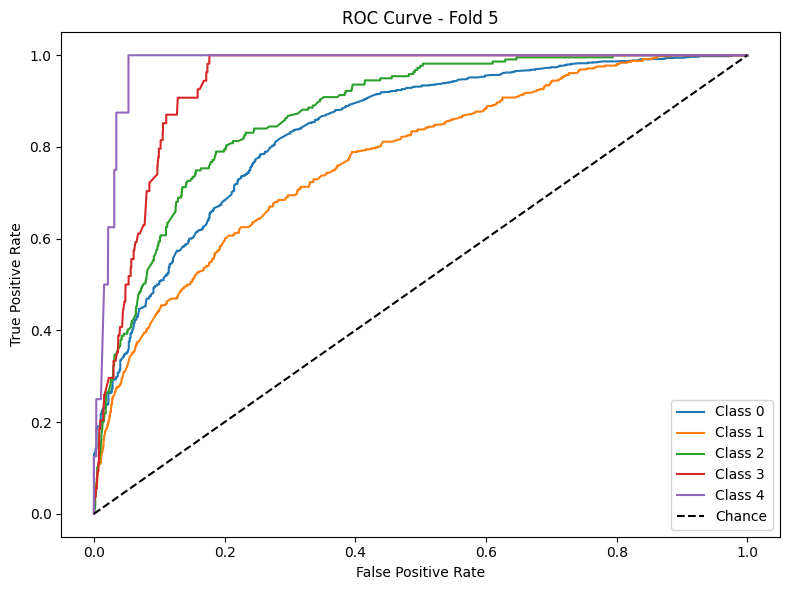


Average Accuracy: 0.7152
Average F1 Macro: 0.4170
Average AUC: 0.8763

Feature Importances:
remaining_time                         12.648214
video                                  11.320810
school                                 10.046343
exercise_count                          7.620889
encoded_field_sum                       7.547104
video_count                             6.896891
duration_days                           6.745549
assignment                              6.006918
chapter_count                           5.597624
user_month                              5.174676
num_prerequisites                       3.380177
total_words_phase1                      3.250851
total_neutral1                          1.673724
total_words_phase2                      1.586918
entropy_time_comment_phase1             1.447691
user_past_course_count                  1.076750
exam                                    0.837472
total_positive1                         0.783957
user_time_since_last_cour

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83      1361
           1       0.67      0.22      0.33       459
           2       0.55      0.27      0.36       198
           3       0.19      0.12      0.15        49
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2074
   macro avg       0.43      0.32      0.34      2074
weighted avg       0.69      0.71      0.66      2074



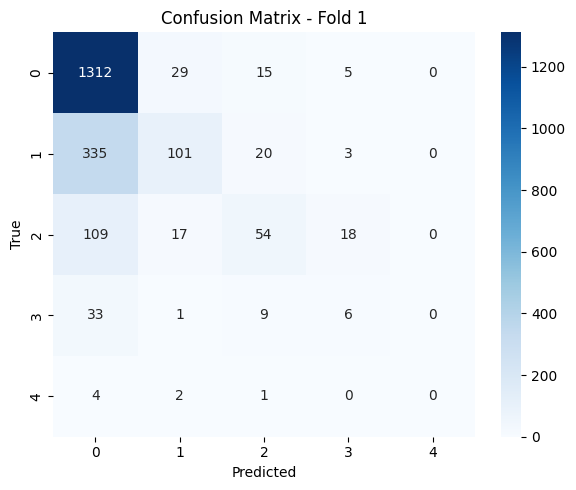

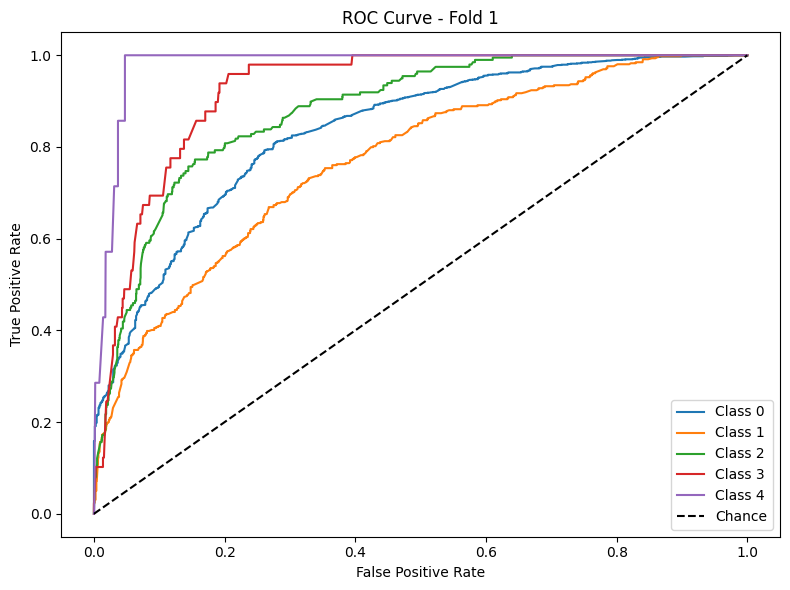

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.96      0.83      1360
           1       0.60      0.26      0.36       459
           2       0.64      0.27      0.38       198
           3       0.52      0.22      0.31        50
           4       0.00      0.00      0.00         7

    accuracy                           0.72      2074
   macro avg       0.50      0.34      0.38      2074
weighted avg       0.69      0.72      0.67      2074



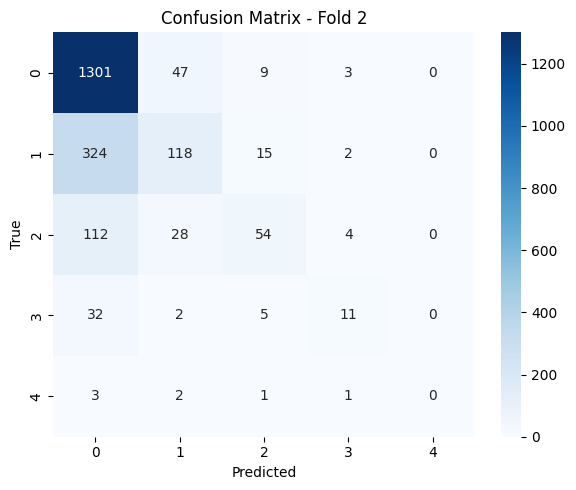

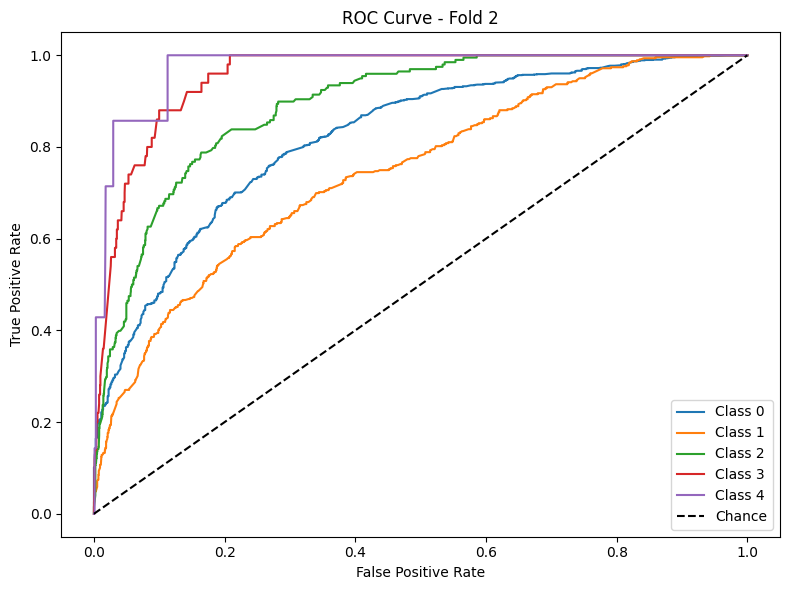

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1360
           1       0.61      0.25      0.36       459
           2       0.46      0.25      0.32       198
           3       0.54      0.28      0.37        50
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2074
   macro avg       0.47      0.35      0.38      2074
weighted avg       0.68      0.71      0.67      2074



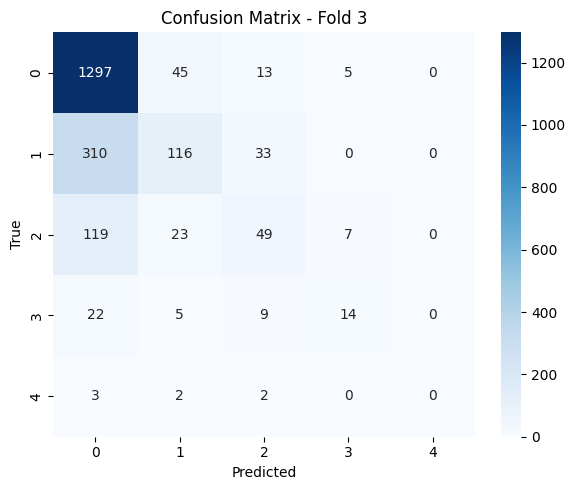

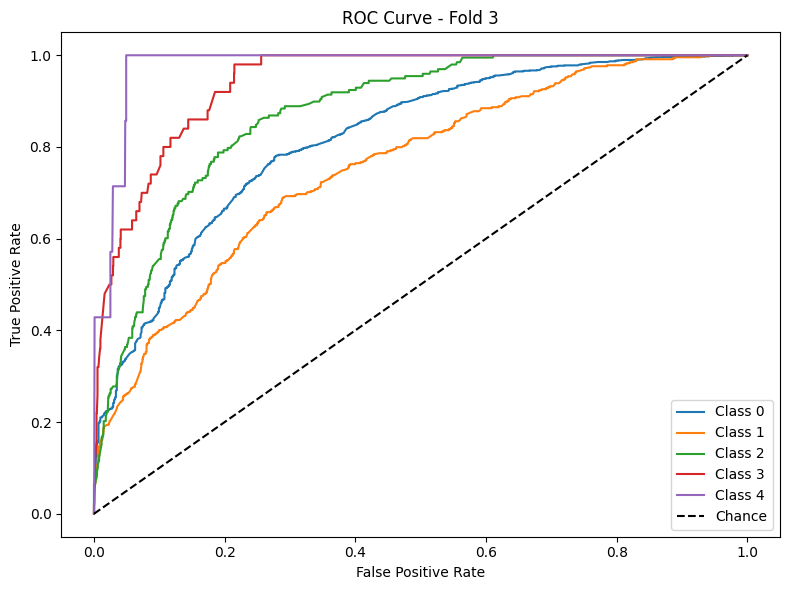


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82      1360
           1       0.60      0.25      0.36       459
           2       0.51      0.25      0.34       198
           3       0.65      0.22      0.33        50
           4       1.00      0.14      0.25         7

    accuracy                           0.71      2074
   macro avg       0.70      0.36      0.42      2074
weighted avg       0.68      0.71      0.66      2074



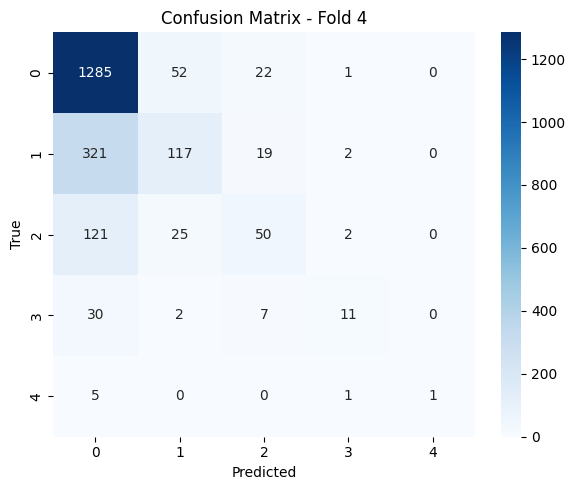

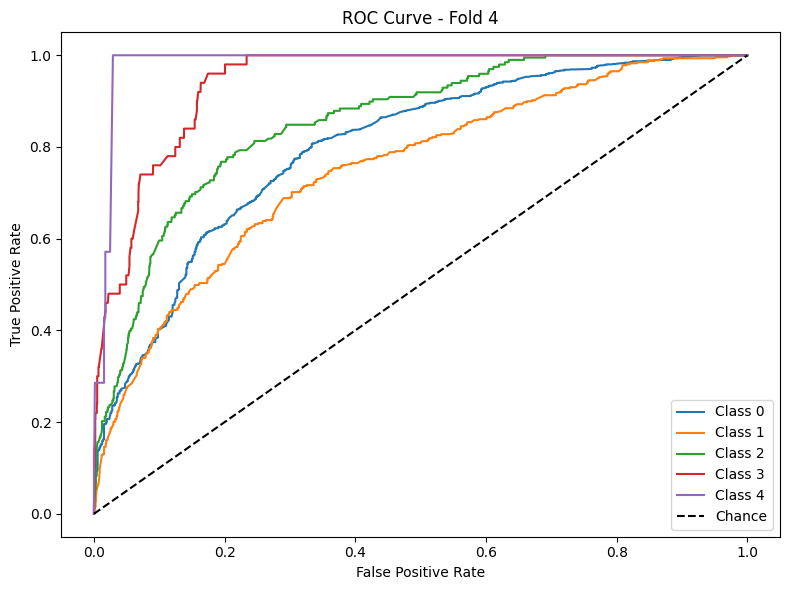

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.95      0.83      1360
           1       0.60      0.23      0.33       460
           2       0.49      0.31      0.38       197
           3       0.44      0.16      0.24        49
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2073
   macro avg       0.45      0.33      0.36      2073
weighted avg       0.67      0.71      0.66      2073



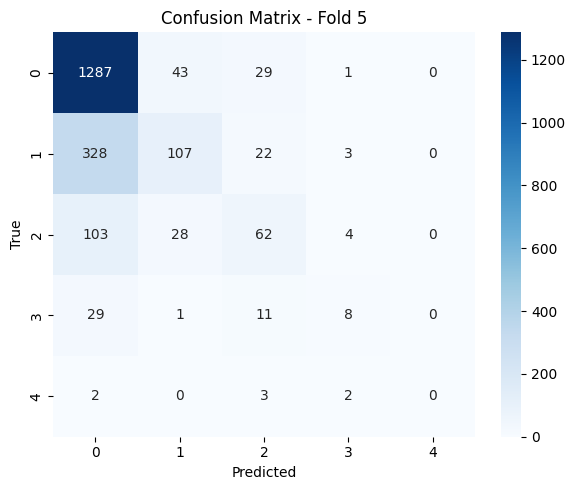

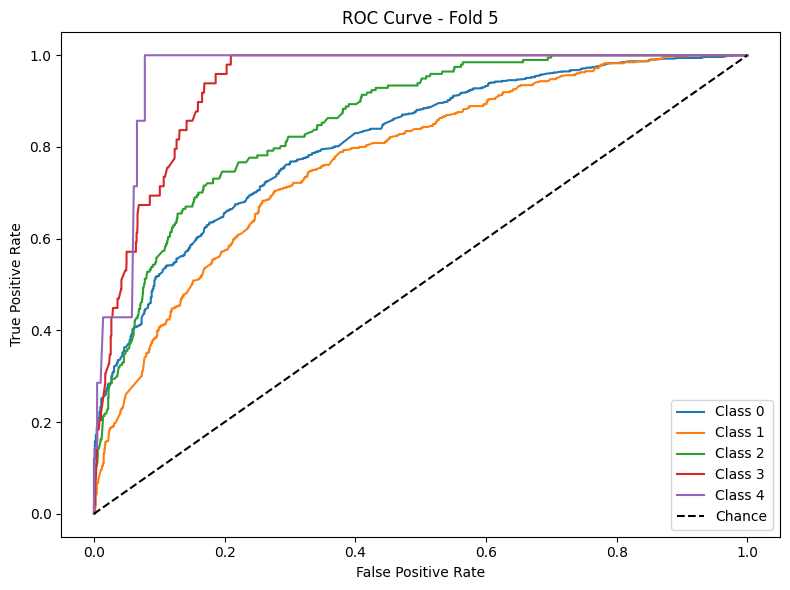


Average Accuracy: 0.7099
Average F1 Macro: 0.3729
Average AUC: 0.8723

Feature Importances:
video                                  17.425577
exercise_count                         11.363219
assignment                             10.549625
video_count                             9.046470
remaining_time                          7.537445
encoded_field_sum                       7.315001
duration_days                           6.687004
school                                  5.445774
num_prerequisites                       4.833147
chapter_count                           3.567379
user_month                              2.979736
total_words_phase1                      1.697972
total_words_phase3                      1.071100
certificate                             0.893472
total_words_phase2                      0.872271
user_time_since_last_course             0.704917
total_neutral3                          0.661365
user_past_course_count                  0.634332
entropy_time_comment_phas

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Fold 1] Best Parameters Found: {'rsm': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 8, 'border_count': 32}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1000
           1       0.63      0.34      0.44       355
           2       0.43      0.36      0.39       139
           3       0.30      0.28      0.29        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1539
   macro avg       0.43      0.38      0.39      1539
weighted avg       0.69      0.72      0.69      1539



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


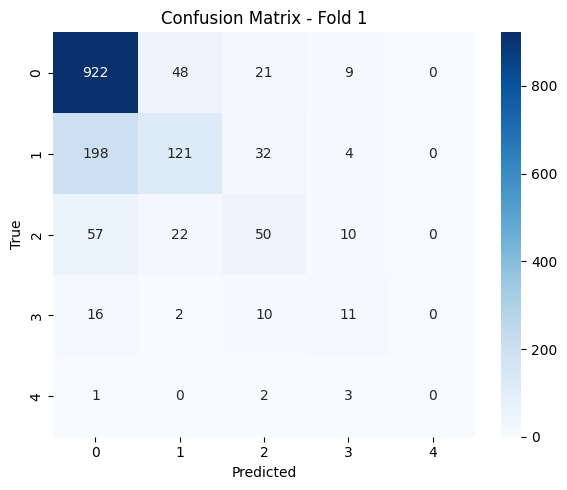

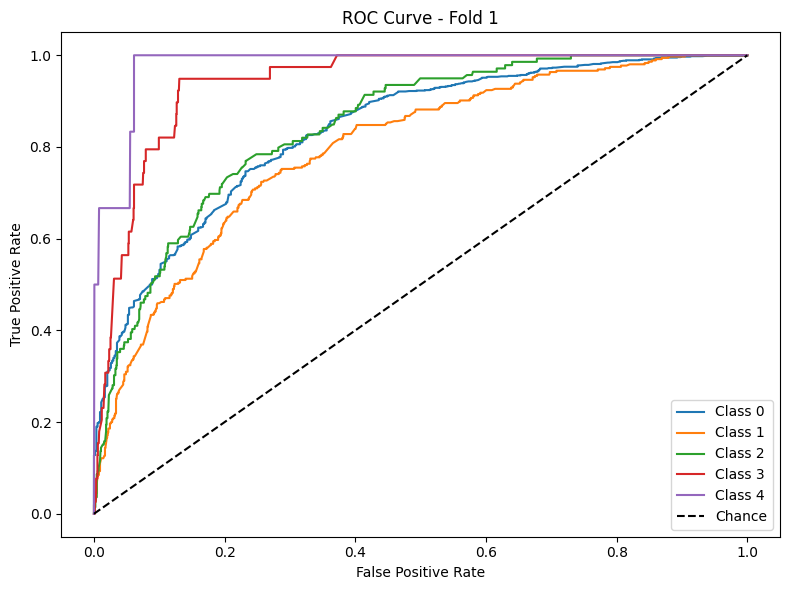


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.84      1000
           1       0.63      0.34      0.44       355
           2       0.58      0.45      0.51       139
           3       0.46      0.15      0.23        40
           4       0.00      0.00      0.00         5

    accuracy                           0.73      1539
   macro avg       0.49      0.38      0.40      1539
weighted avg       0.71      0.73      0.70      1539



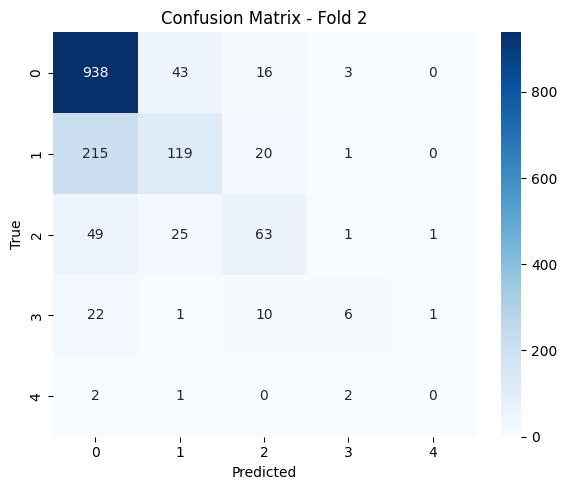

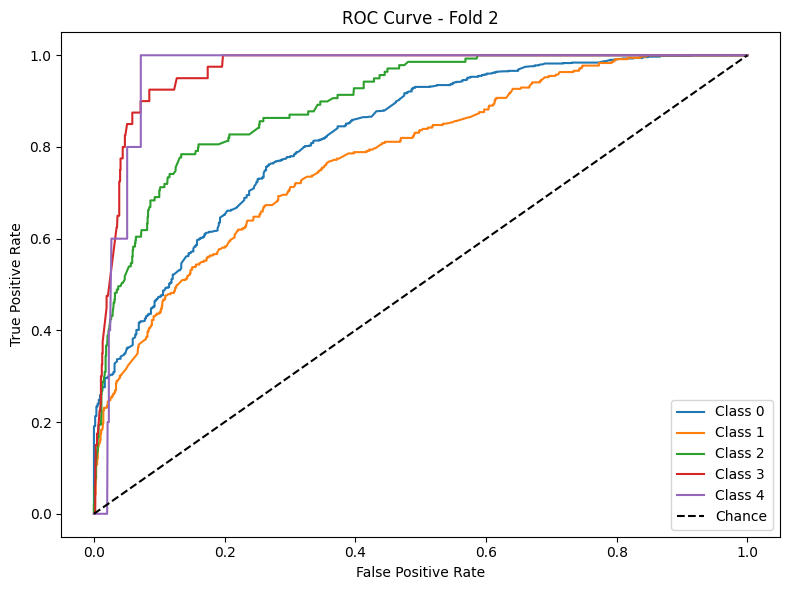


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85       999
           1       0.65      0.36      0.46       355
           2       0.55      0.37      0.45       139
           3       0.39      0.23      0.29        40
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1539
   macro avg       0.47      0.38      0.41      1539
weighted avg       0.71      0.73      0.70      1539



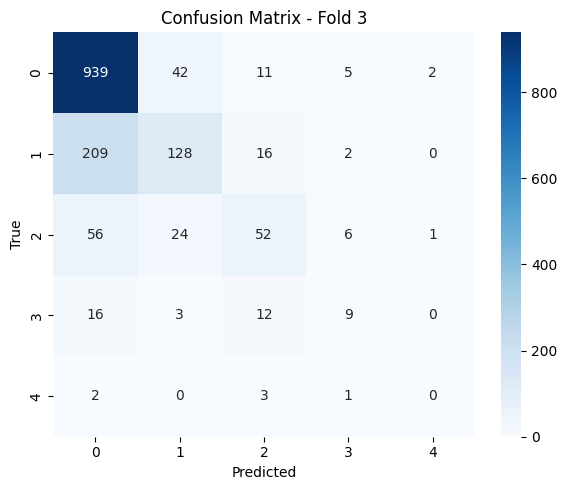

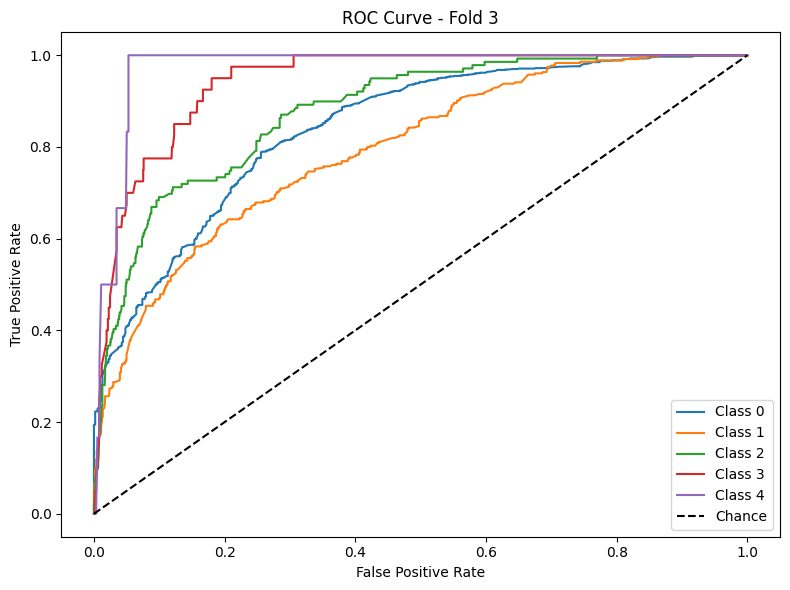


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.95      0.85       999
           1       0.64      0.35      0.45       356
           2       0.54      0.37      0.44       138
           3       0.16      0.08      0.10        39
           4       0.00      0.00      0.00         6

    accuracy                           0.73      1538
   macro avg       0.42      0.35      0.37      1538
weighted avg       0.70      0.73      0.70      1538



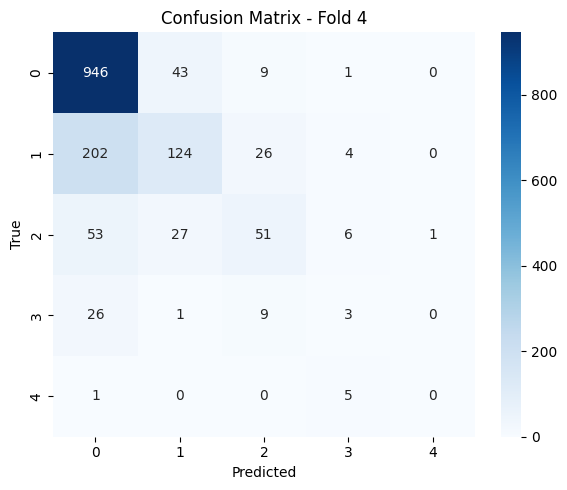

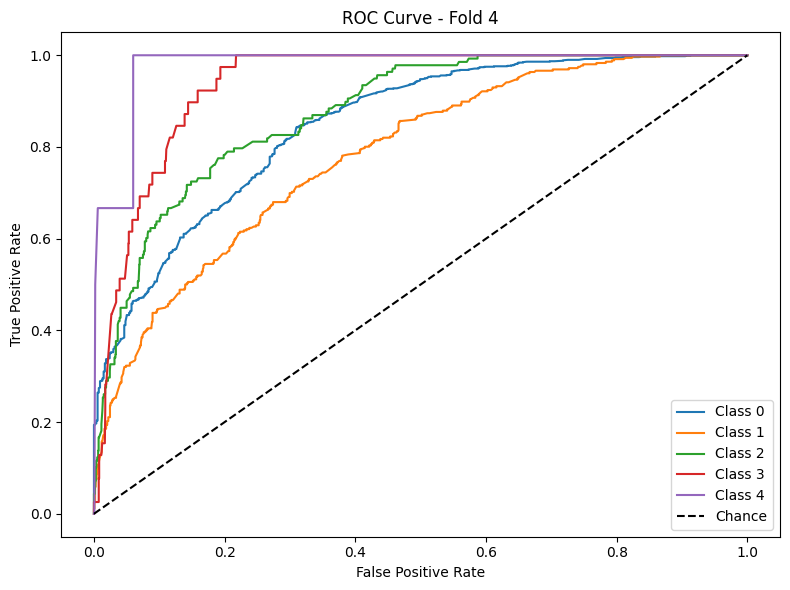


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84       999
           1       0.62      0.36      0.45       356
           2       0.45      0.36      0.40       138
           3       0.45      0.26      0.33        39
           4       0.25      0.17      0.20         6

    accuracy                           0.72      1538
   macro avg       0.51      0.41      0.44      1538
weighted avg       0.70      0.72      0.70      1538



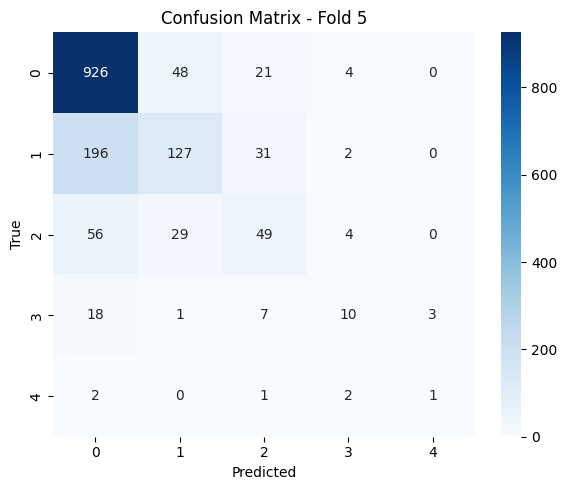

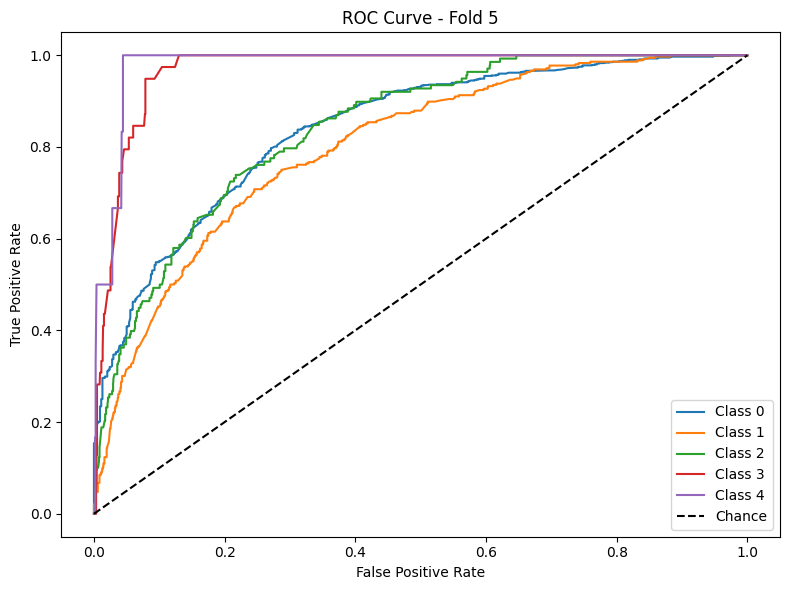


Average Accuracy: 0.7273
Average F1 Macro: 0.4033
Average AUC: 0.8844

Feature Importances:
remaining_time                         10.985493
school                                  9.937264
video                                   7.868253
assignment                              7.678287
video_count                             7.453783
exercise_count                          6.465667
encoded_field_sum                       6.363891
duration_days                           6.339225
user_month                              4.369663
chapter_count                           4.036748
num_prerequisites                       3.303558
total_words_phase1                      2.591213
total_neutral1                          1.771502
total_words_phase3                      1.570763
total_words_phase4                      1.497355
user_time_since_last_course             1.010366
total_words_phase2                      0.971665
exercise_perc_real_score_mean_4         0.893584
exercise_correct_sum_4   

In [5]:
# TRAINING ALL PHASES
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample=sample)
    if sample:
        temp = "sample"
    else:
        temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics

## Predict on Test Data

In [6]:
# =================== PREDICTION ===================
def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    X_test_scaled = scaler.transform(X_test)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


Classification Report:

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       568
           1       0.67      0.16      0.26        63
           2       0.50      0.14      0.22        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.83       698
   macro avg       0.40      0.26      0.28       698
weighted avg       0.78      0.83      0.78       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


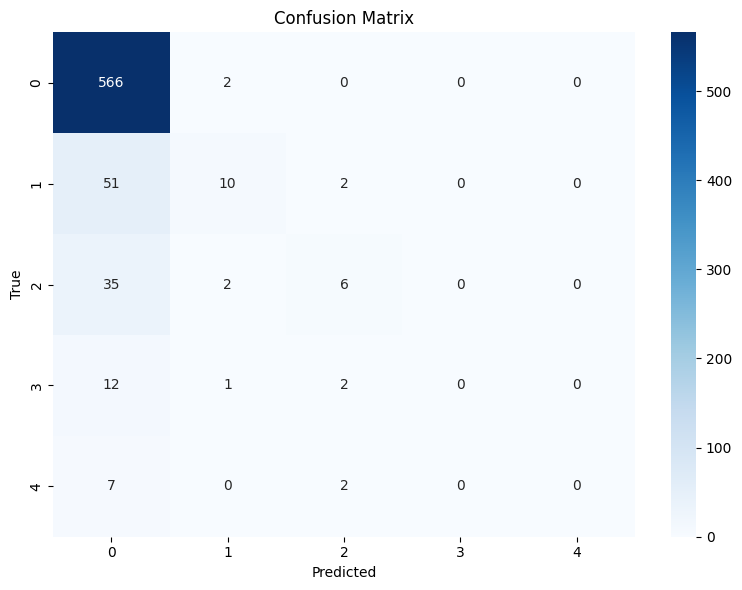


Test AUC (macro-average, OVR): 0.8254


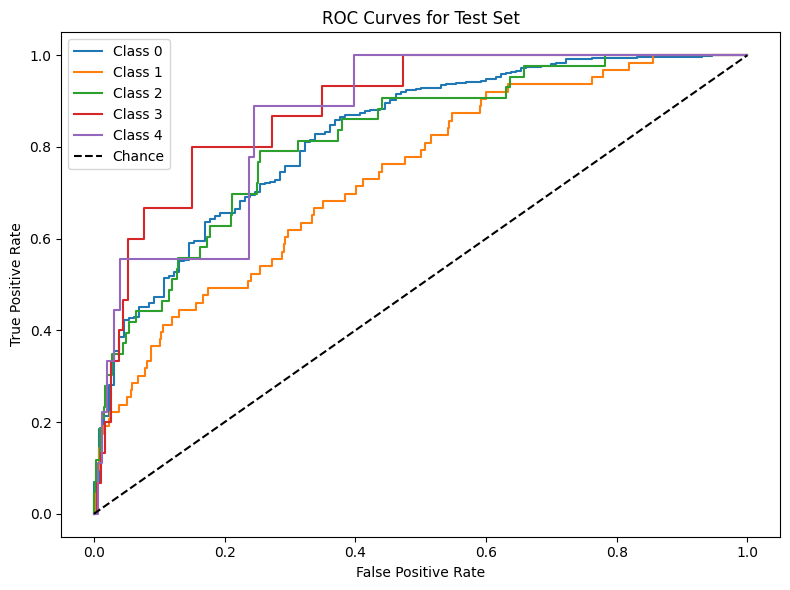


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.97      0.91       544
           1       0.27      0.19      0.22        59
           2       0.39      0.17      0.23        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.82       668
   macro avg       0.30      0.26      0.27       668
weighted avg       0.75      0.82      0.78       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


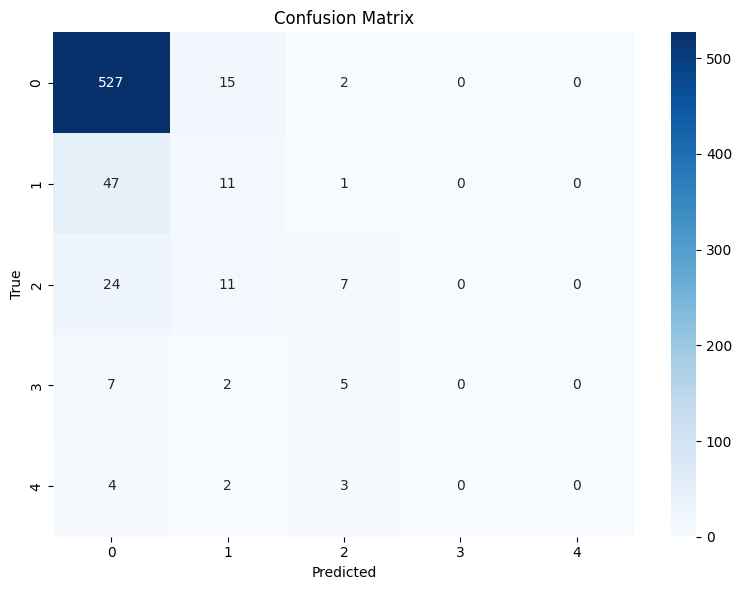


Test AUC (macro-average, OVR): 0.8534


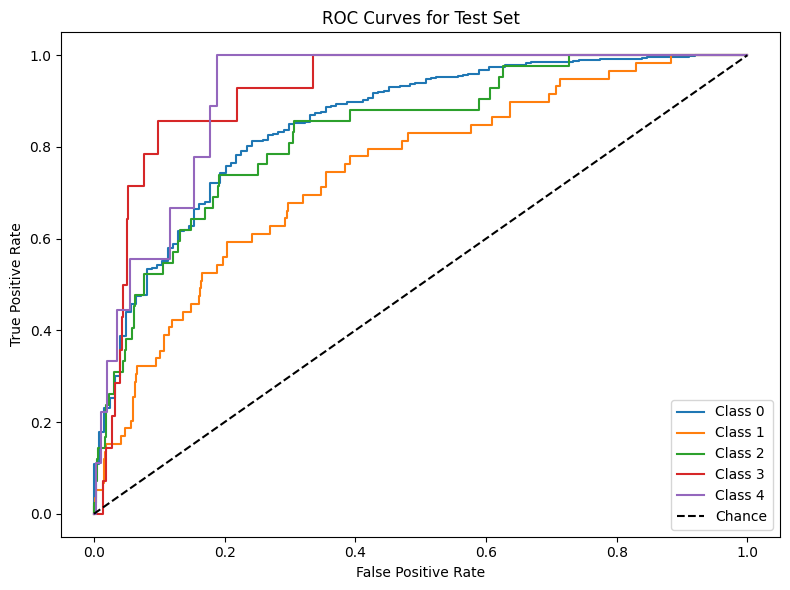


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       455
           1       0.20      0.10      0.13        52
           2       0.22      0.14      0.17        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.80       554
   macro avg       0.26      0.24      0.24       554
weighted avg       0.73      0.80      0.76       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


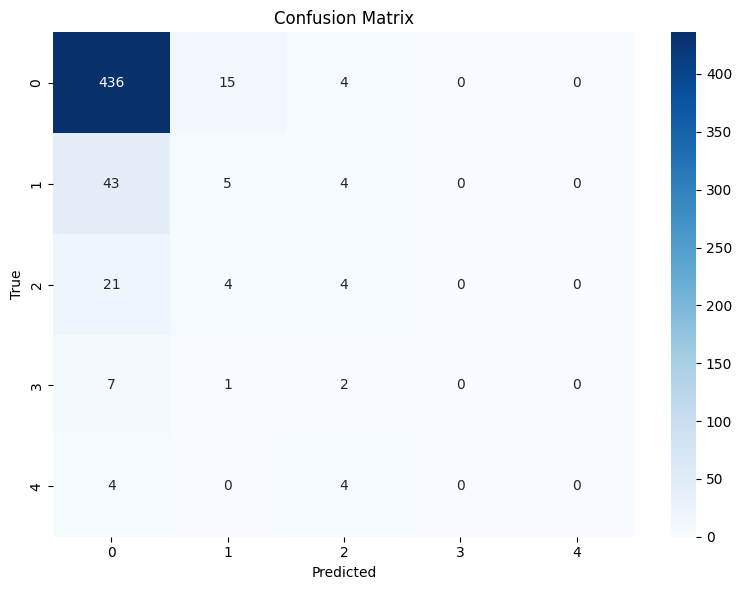


Test AUC (macro-average, OVR): 0.8056


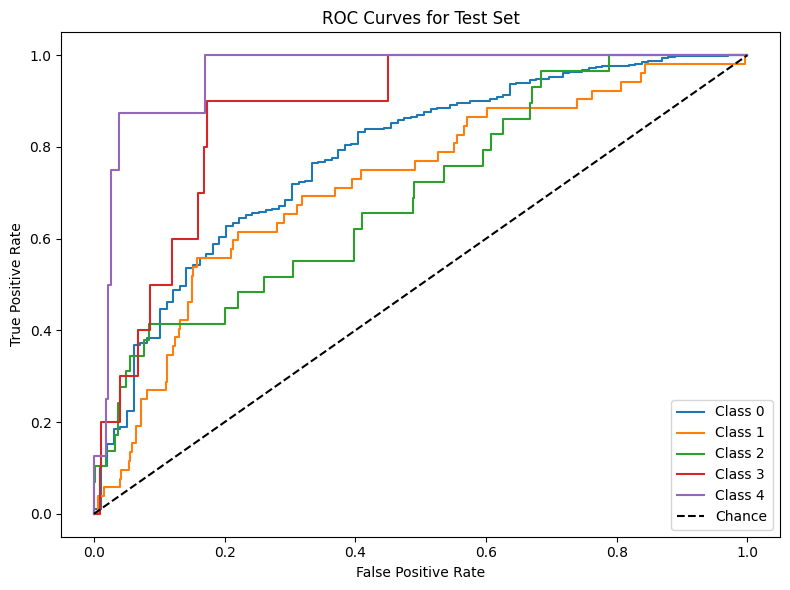


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       395
           1       0.30      0.07      0.12        40
           2       0.33      0.08      0.13        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.83       477
   macro avg       0.30      0.23      0.23       477
weighted avg       0.74      0.83      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


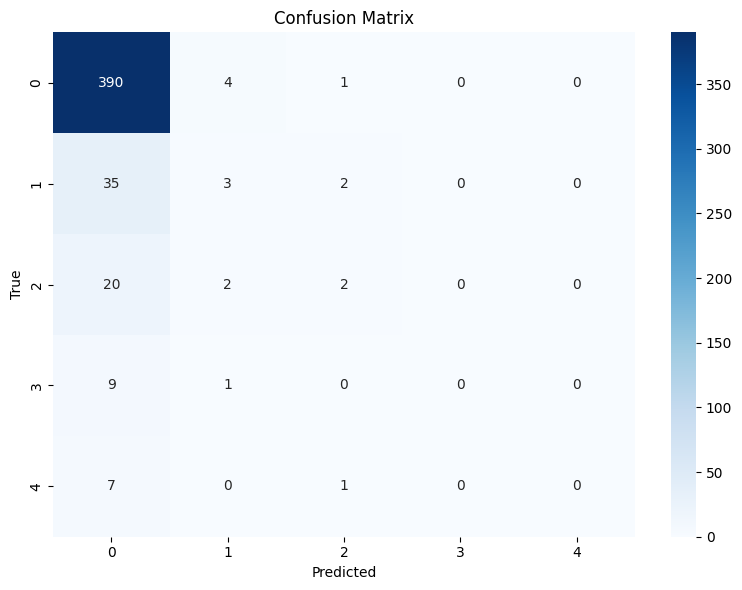


Test AUC (macro-average, OVR): 0.7945


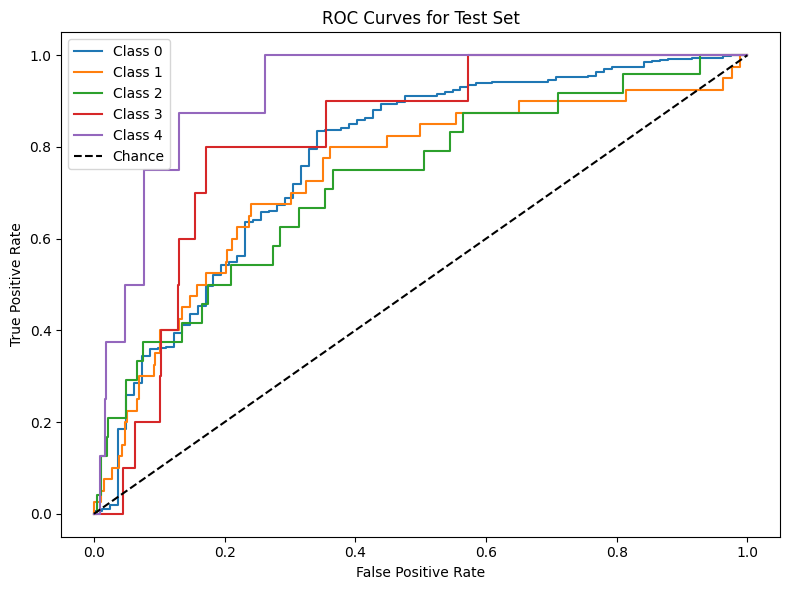

In [7]:
# Predict loop for all phases
for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)

# Add SMOTE Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Fold 1] Best Parameters Found: {'rsm': 0.8, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 10, 'border_count': 32}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1785
           1       0.52      0.50      0.51       604
           2       0.35      0.47      0.40       258
           3       0.19      0.42      0.26        59
           4       0.05      0.11      0.07         9

    accuracy                           0.67      2715
   macro avg       0.39      0.45      0.41      2715
weighted avg       0.70      0.67      0.68      2715



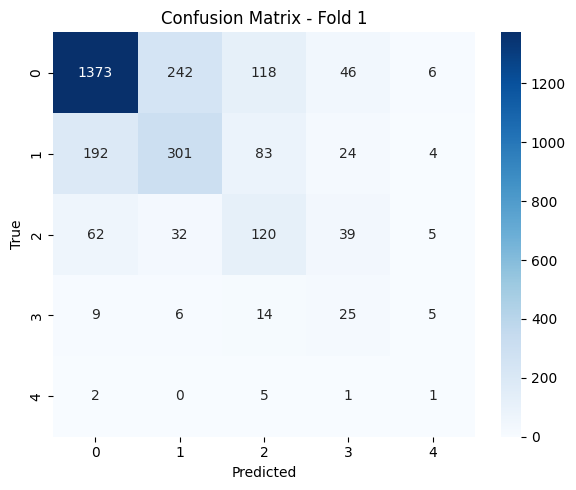

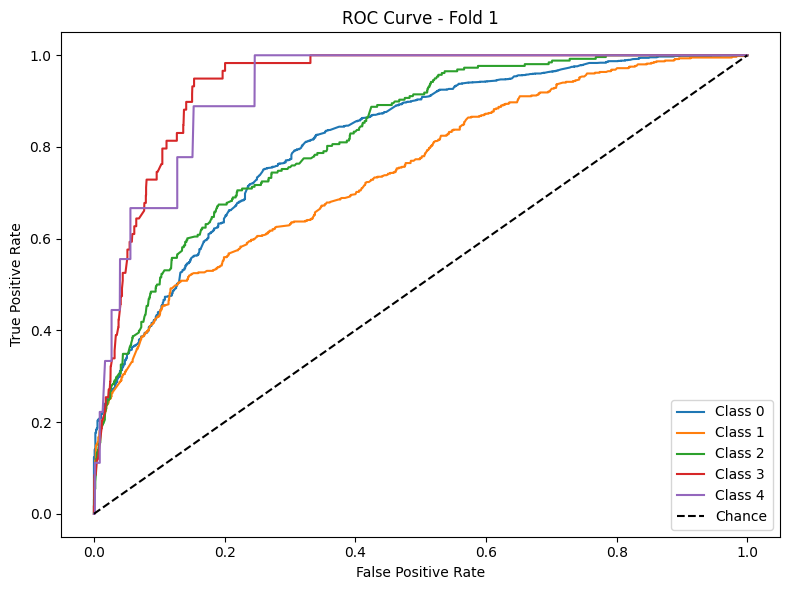


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78      1786
           1       0.46      0.46      0.46       603
           2       0.39      0.44      0.41       258
           3       0.22      0.63      0.32        59
           4       0.27      0.50      0.35         8

    accuracy                           0.65      2714
   macro avg       0.43      0.56      0.47      2714
weighted avg       0.68      0.65      0.67      2714



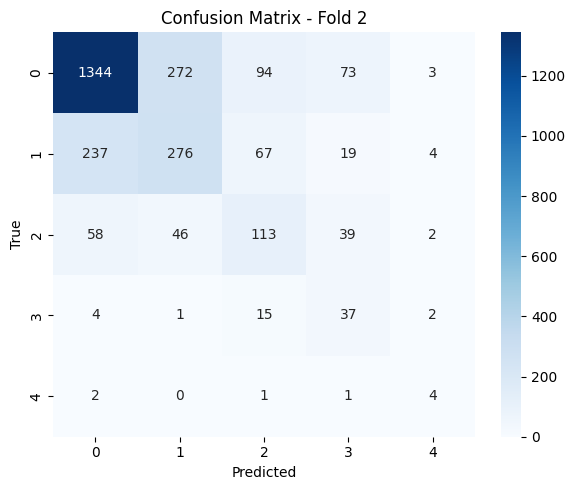

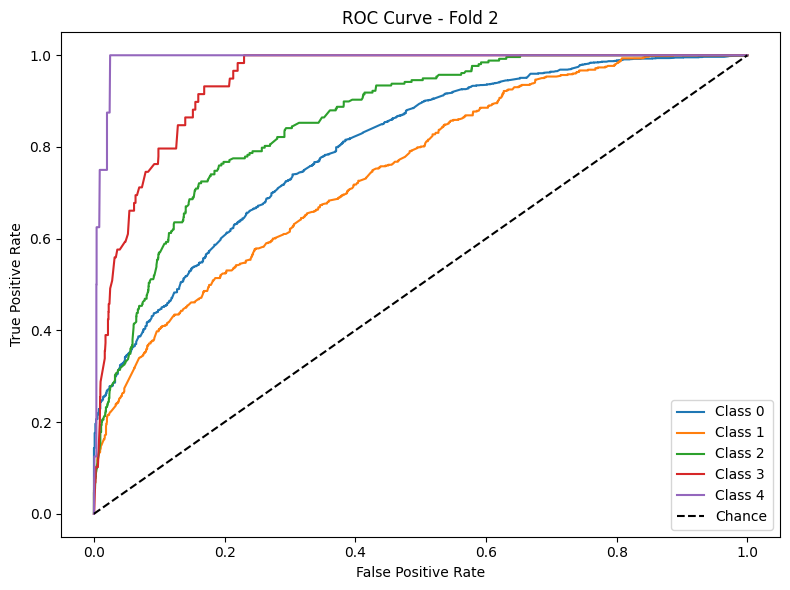


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79      1786
           1       0.48      0.52      0.50       603
           2       0.39      0.53      0.45       258
           3       0.22      0.47      0.30        59
           4       0.27      0.38      0.32         8

    accuracy                           0.66      2714
   macro avg       0.44      0.53      0.47      2714
weighted avg       0.70      0.66      0.68      2714



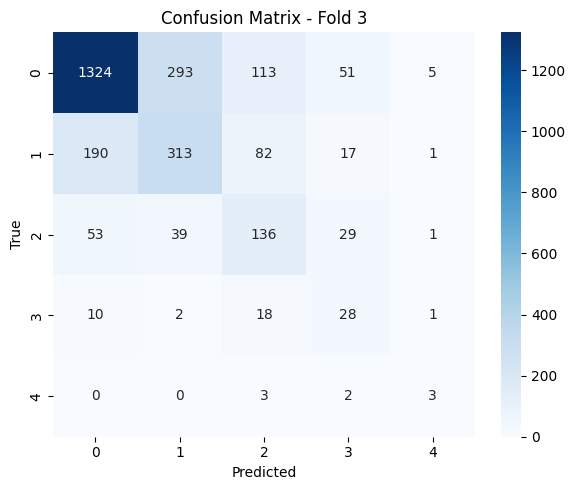

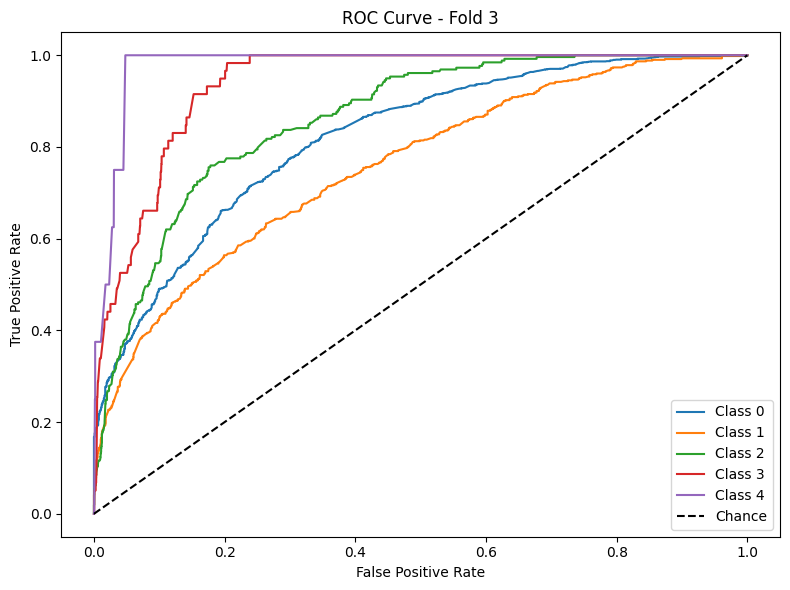


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1785
           1       0.51      0.52      0.51       603
           2       0.41      0.54      0.46       258
           3       0.21      0.39      0.27        59
           4       0.09      0.11      0.10         9

    accuracy                           0.68      2714
   macro avg       0.41      0.47      0.43      2714
weighted avg       0.71      0.68      0.69      2714



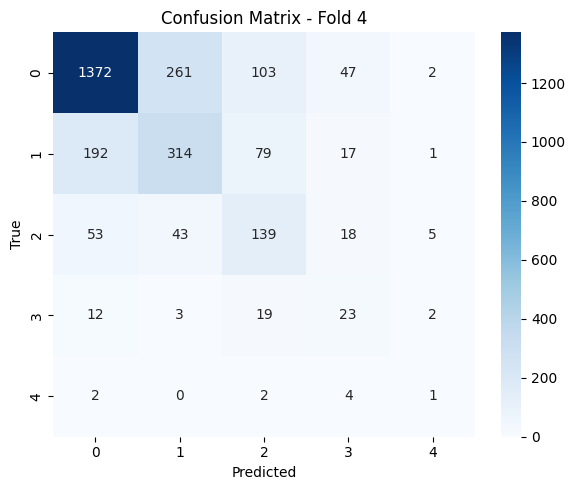

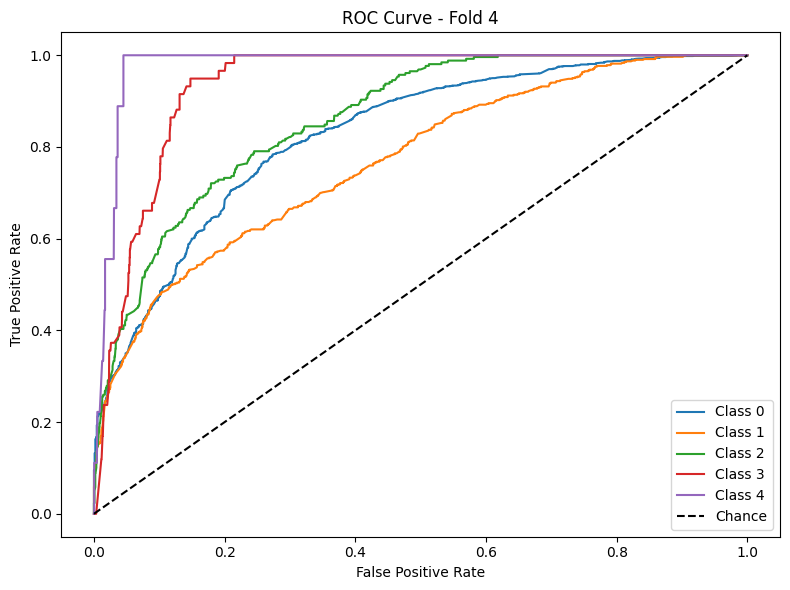


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1785
           1       0.50      0.49      0.49       603
           2       0.42      0.50      0.45       258
           3       0.18      0.49      0.26        59
           4       0.27      0.33      0.30         9

    accuracy                           0.67      2714
   macro avg       0.44      0.52      0.46      2714
weighted avg       0.70      0.67      0.69      2714



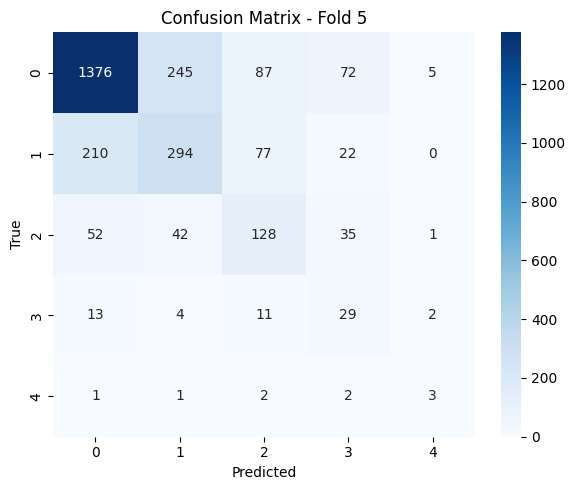

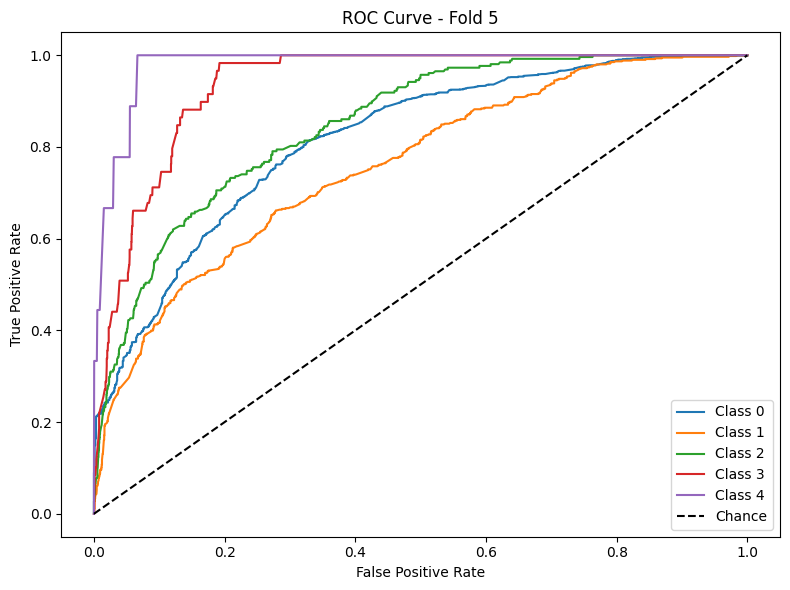


Average Accuracy: 0.6689
Average F1 Macro: 0.4474
Average AUC: 0.8665

Feature Importances:
remaining_time                         13.521568
school                                 11.962157
user_month                              9.345491
assignment                              8.669134
video                                   8.486309
encoded_field_sum                       7.594258
video_count                             6.689733
exercise_count                          6.599345
chapter_count                           5.616374
duration_days                           5.290426
total_words_phase1                      3.944218
total_neutral1                          2.620840
num_prerequisites                       2.068528
user_past_course_count                  1.390888
exercise_perc_real_score_mean_1         1.123700
exercise_correct_sum_1                  0.931988
entropy_time_comment_phase1             0.876327
total_positive1                         0.740072
user_time_since_last_cour

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Fold 1] Best Parameters Found: {'rsm': 0.8, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 8, 'border_count': 128}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1489
           1       0.47      0.45      0.46       488
           2       0.40      0.53      0.46       220
           3       0.24      0.48      0.32        54
           4       0.22      0.22      0.22         9

    accuracy                           0.67      2260
   macro avg       0.43      0.49      0.45      2260
weighted avg       0.70      0.67      0.68      2260



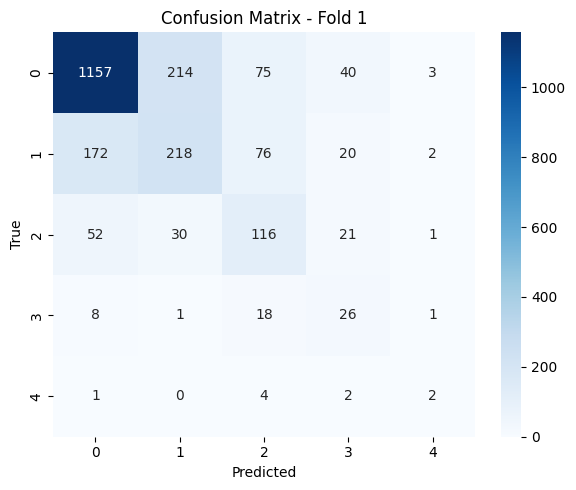

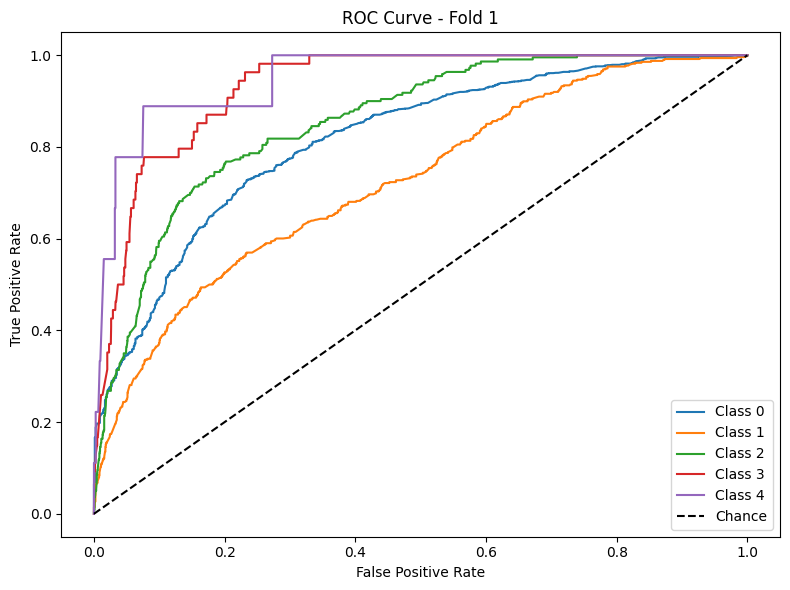


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      1489
           1       0.46      0.47      0.47       489
           2       0.36      0.46      0.41       219
           3       0.25      0.53      0.34        55
           4       0.20      0.38      0.26         8

    accuracy                           0.66      2260
   macro avg       0.42      0.52      0.45      2260
weighted avg       0.69      0.66      0.67      2260



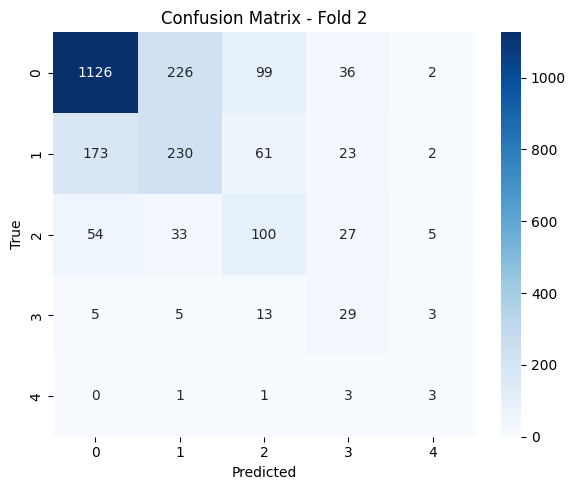

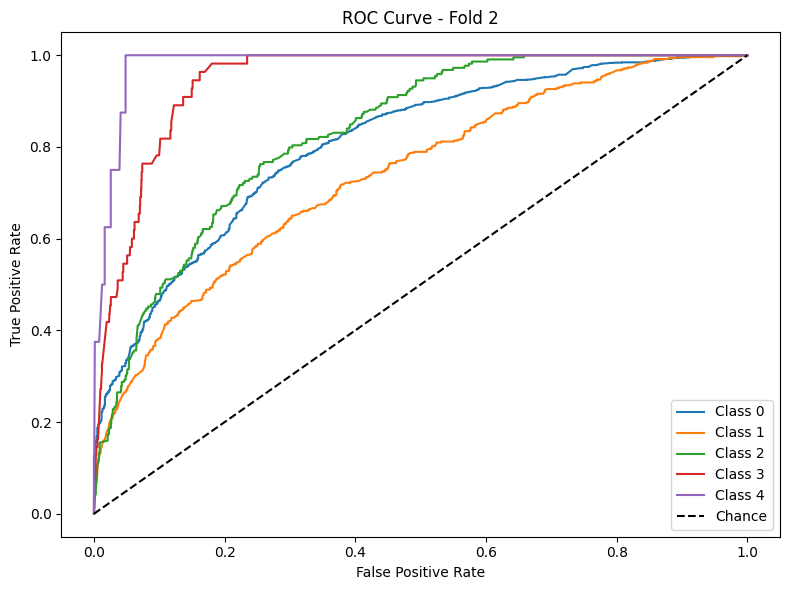


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1489
           1       0.47      0.45      0.46       489
           2       0.41      0.57      0.48       219
           3       0.19      0.39      0.26        54
           4       0.40      0.50      0.44         8

    accuracy                           0.67      2259
   macro avg       0.46      0.53      0.49      2259
weighted avg       0.70      0.67      0.68      2259



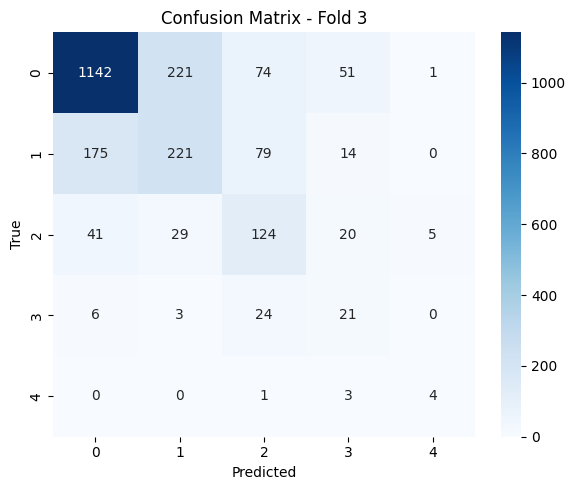

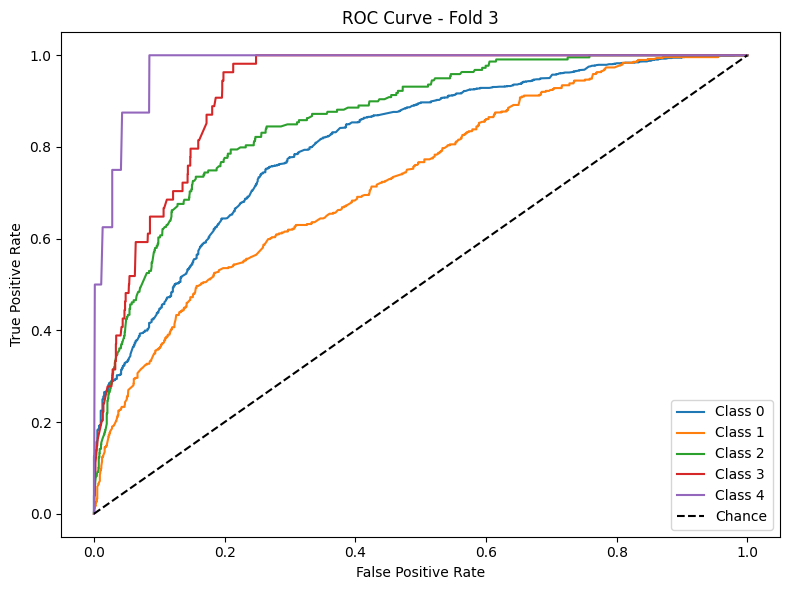


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1489
           1       0.48      0.46      0.47       489
           2       0.39      0.49      0.44       219
           3       0.26      0.56      0.36        54
           4       0.27      0.50      0.35         8

    accuracy                           0.67      2259
   macro avg       0.44      0.55      0.48      2259
weighted avg       0.69      0.67      0.67      2259



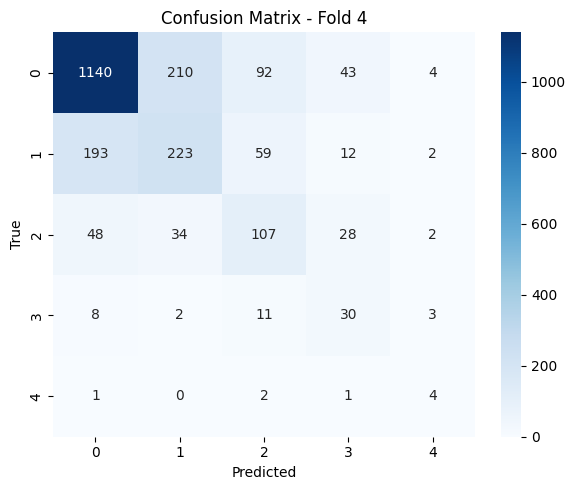

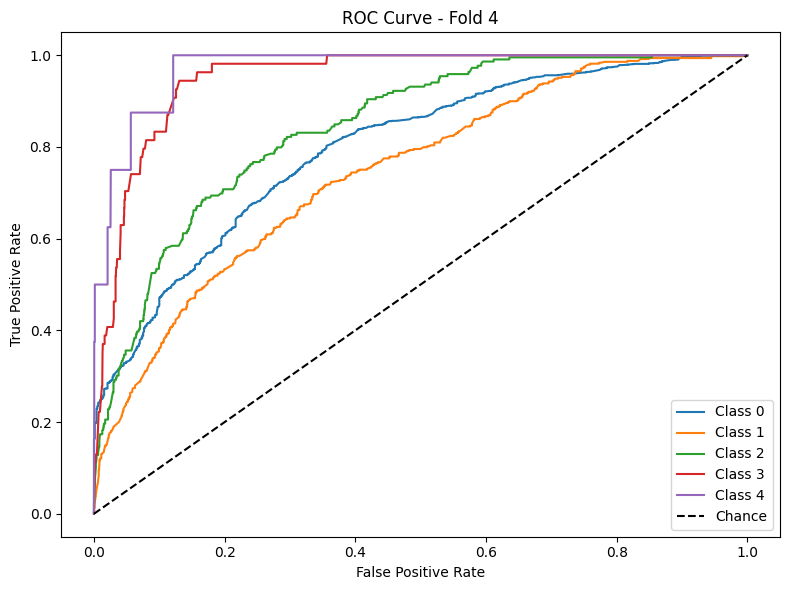


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81      1490
           1       0.48      0.49      0.49       488
           2       0.36      0.52      0.43       219
           3       0.19      0.31      0.24        54
           4       0.13      0.25      0.17         8

    accuracy                           0.67      2259
   macro avg       0.40      0.47      0.43      2259
weighted avg       0.71      0.67      0.69      2259



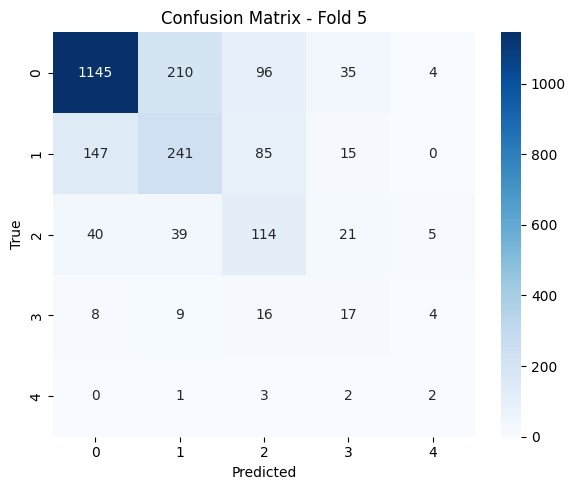

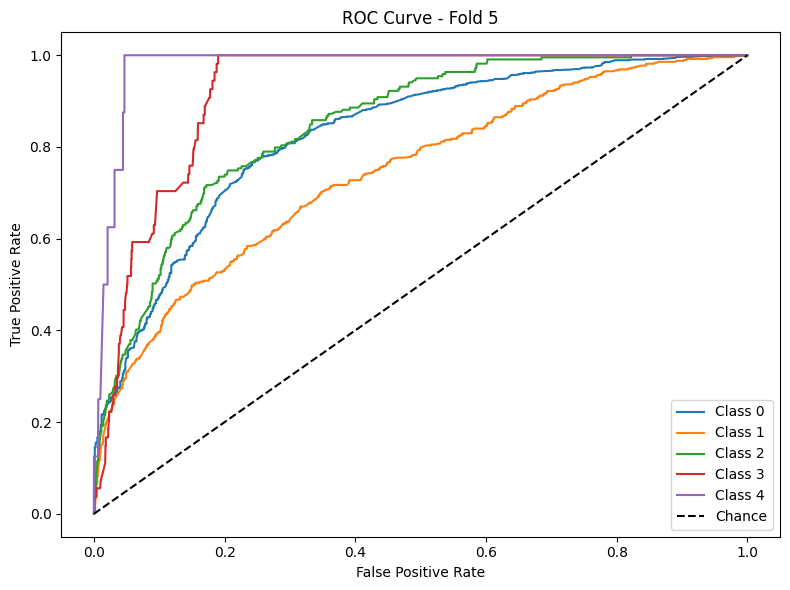


Average Accuracy: 0.6676
Average F1 Macro: 0.4596
Average AUC: 0.8604

Feature Importances:
remaining_time                         12.657355
school                                 12.204815
video                                  11.105859
assignment                              9.463269
encoded_field_sum                       6.821061
user_month                              6.788904
video_count                             6.016381
exercise_count                          6.013032
chapter_count                           5.757629
duration_days                           5.684003
total_words_phase1                      3.265247
num_prerequisites                       3.124573
total_neutral1                          2.134959
user_past_course_count                  1.412548
total_words_phase2                      1.301953
total_neutral2                          0.836261
total_positive1                         0.743492
entropy_time_comment_phase1             0.630056
certificate              

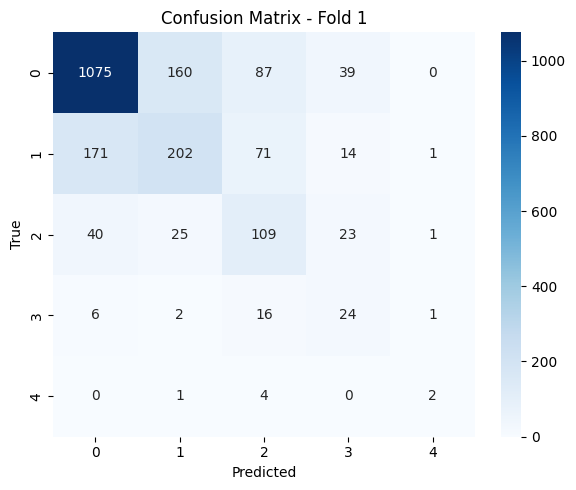

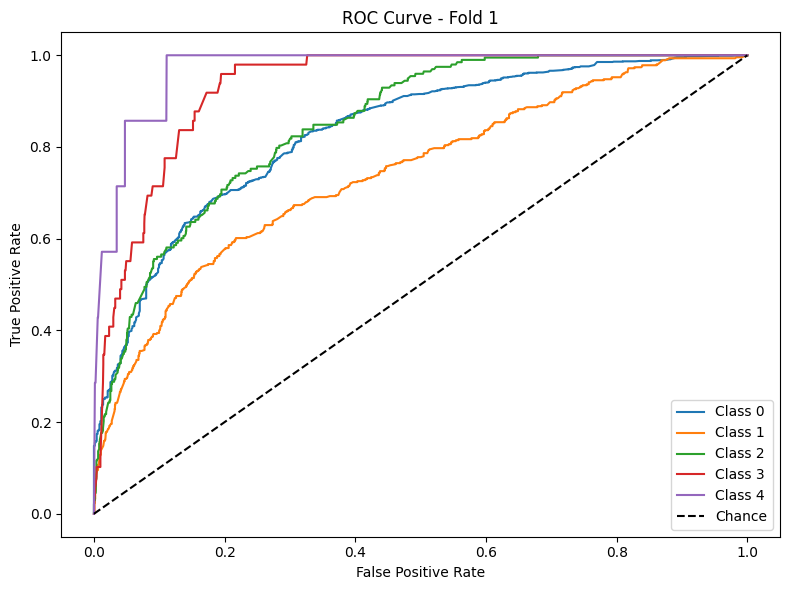


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1360
           1       0.47      0.45      0.46       459
           2       0.42      0.55      0.47       198
           3       0.25      0.56      0.35        50
           4       0.29      0.29      0.29         7

    accuracy                           0.67      2074
   macro avg       0.45      0.52      0.47      2074
weighted avg       0.69      0.67      0.68      2074



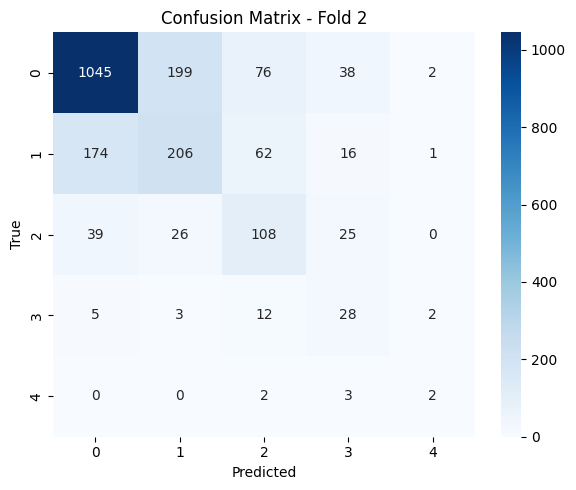

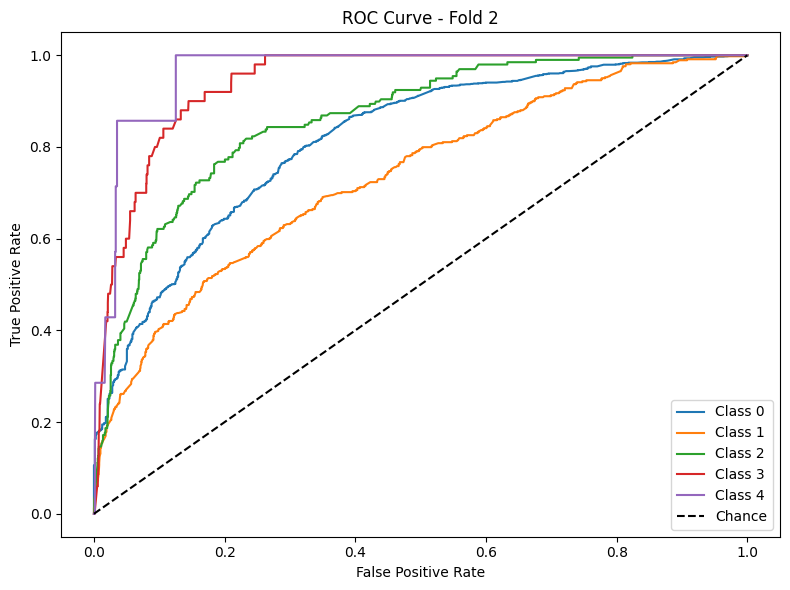


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1360
           1       0.46      0.44      0.45       459
           2       0.37      0.51      0.43       198
           3       0.24      0.44      0.31        50
           4       0.20      0.29      0.24         7

    accuracy                           0.66      2074
   macro avg       0.42      0.49      0.44      2074
weighted avg       0.69      0.66      0.67      2074



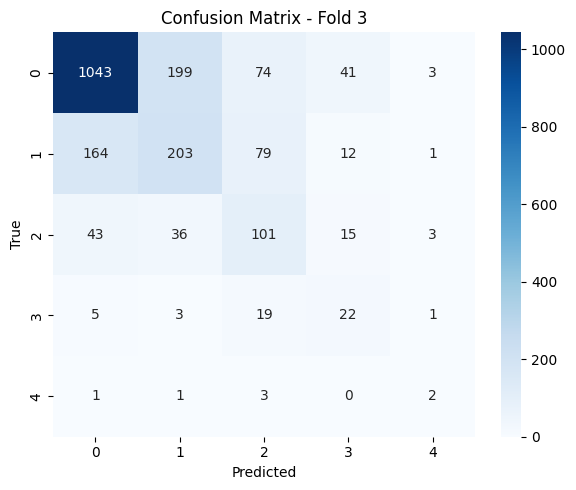

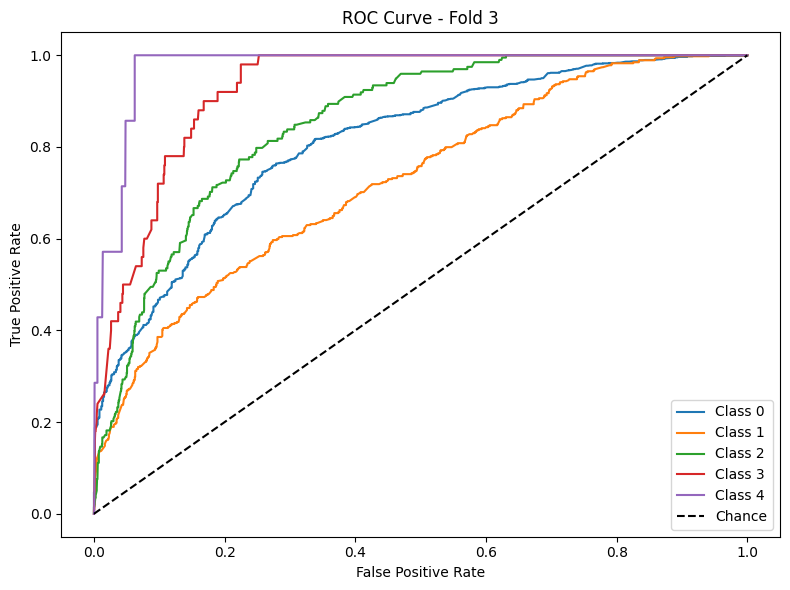


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1360
           1       0.48      0.47      0.47       459
           2       0.41      0.48      0.45       198
           3       0.27      0.44      0.33        50
           4       0.13      0.29      0.18         7

    accuracy                           0.68      2074
   macro avg       0.42      0.49      0.45      2074
weighted avg       0.69      0.68      0.68      2074



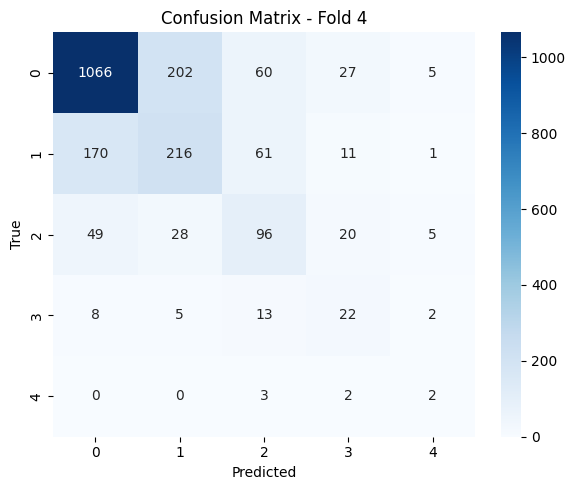

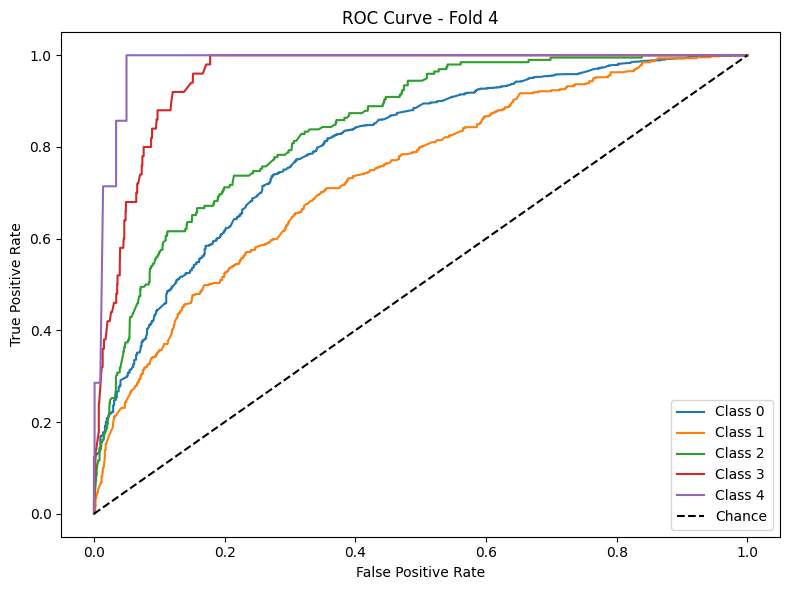


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78      1360
           1       0.46      0.46      0.46       460
           2       0.39      0.51      0.44       197
           3       0.21      0.41      0.28        49
           4       0.07      0.14      0.09         7

    accuracy                           0.65      2073
   macro avg       0.39      0.45      0.41      2073
weighted avg       0.68      0.65      0.67      2073



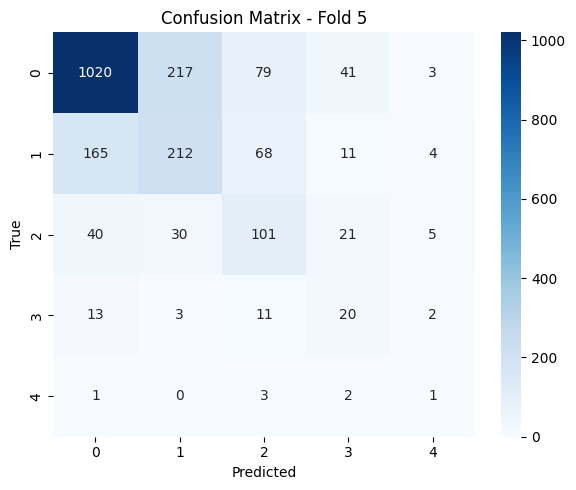

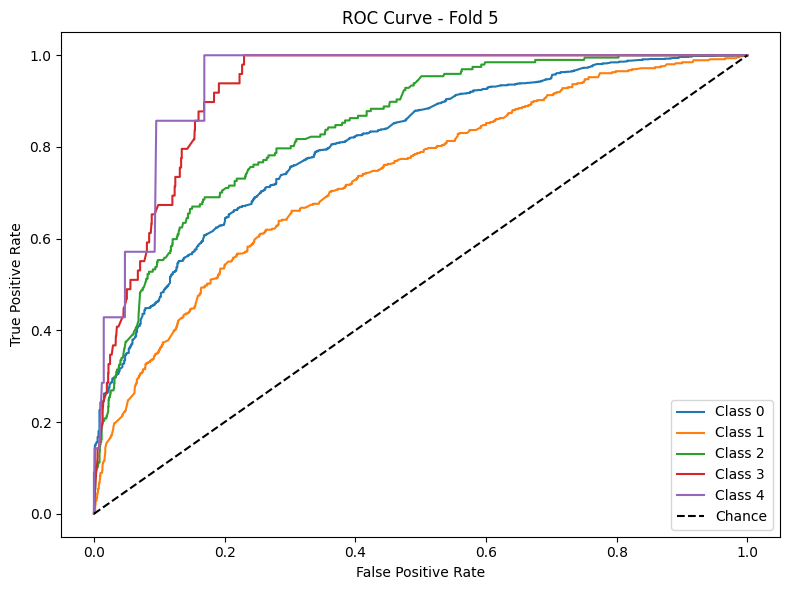


Average Accuracy: 0.6681
Average F1 Macro: 0.4509
Average AUC: 0.8600

Feature Importances:
remaining_time                         11.040939
video                                  10.727386
school                                 10.034823
assignment                              9.323058
encoded_field_sum                       7.285420
exercise_count                          6.926301
chapter_count                           6.635100
user_month                              6.600302
duration_days                           5.509180
video_count                             5.460828
total_words_phase1                      3.583743
num_prerequisites                       2.934436
total_neutral1                          2.394199
user_past_course_count                  1.607642
total_neutral3                          1.126290
total_positive1                         1.080781
total_words_phase2                      1.022749
total_neutral2                          0.838316
total_words_phase3       

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Fold 1] Best Parameters Found: {'rsm': 0.9, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 9, 'border_count': 64}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80      1000
           1       0.51      0.50      0.51       355
           2       0.36      0.43      0.39       139
           3       0.29      0.51      0.37        39
           4       0.25      0.50      0.33         6

    accuracy                           0.67      1539
   macro avg       0.45      0.54      0.48      1539
weighted avg       0.70      0.67      0.68      1539



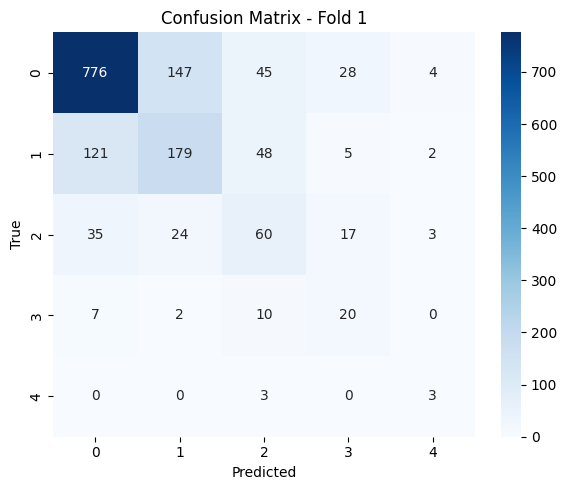

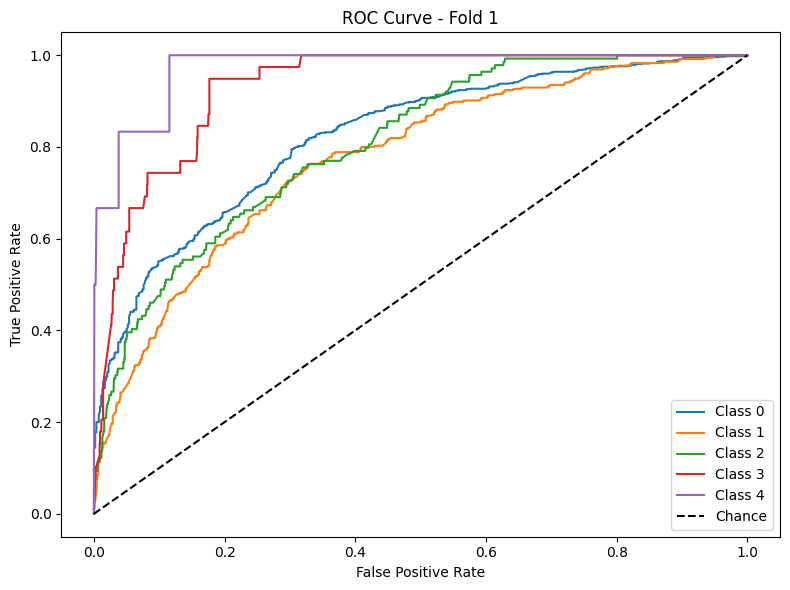


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      1000
           1       0.51      0.50      0.50       355
           2       0.51      0.53      0.52       139
           3       0.26      0.55      0.35        40
           4       0.00      0.00      0.00         5

    accuracy                           0.68      1539
   macro avg       0.42      0.47      0.43      1539
weighted avg       0.70      0.68      0.69      1539



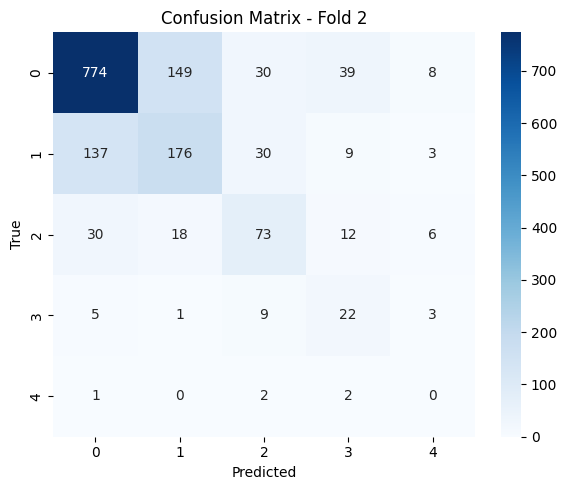

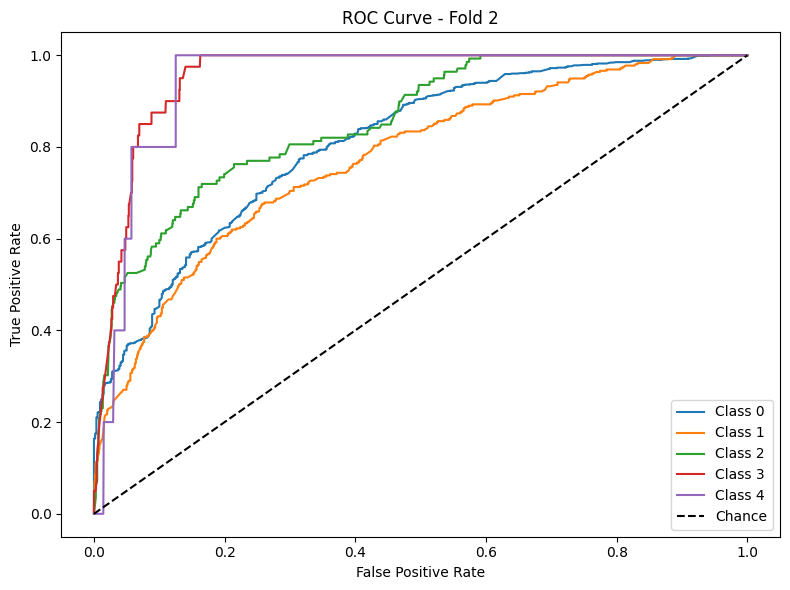


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       999
           1       0.54      0.55      0.54       355
           2       0.48      0.56      0.52       139
           3       0.27      0.45      0.34        40
           4       0.25      0.17      0.20         6

    accuracy                           0.70      1539
   macro avg       0.47      0.50      0.48      1539
weighted avg       0.72      0.70      0.71      1539



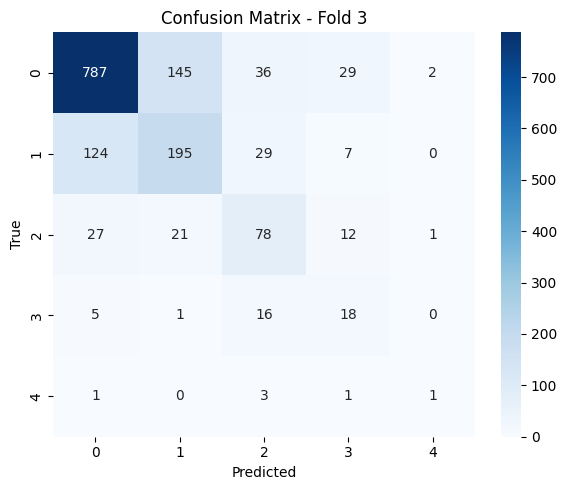

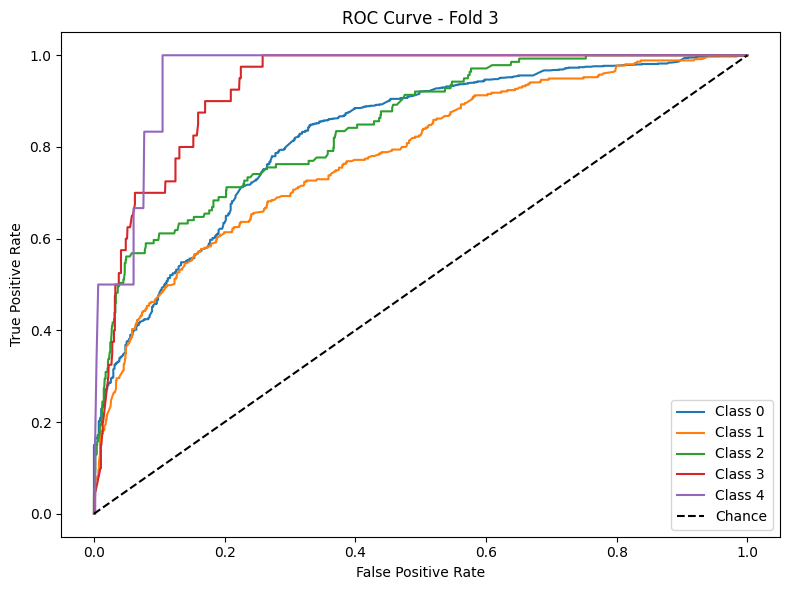


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       999
           1       0.51      0.47      0.49       356
           2       0.46      0.52      0.49       138
           3       0.22      0.44      0.29        39
           4       0.21      0.67      0.32         6

    accuracy                           0.69      1538
   macro avg       0.45      0.58      0.48      1538
weighted avg       0.71      0.69      0.70      1538



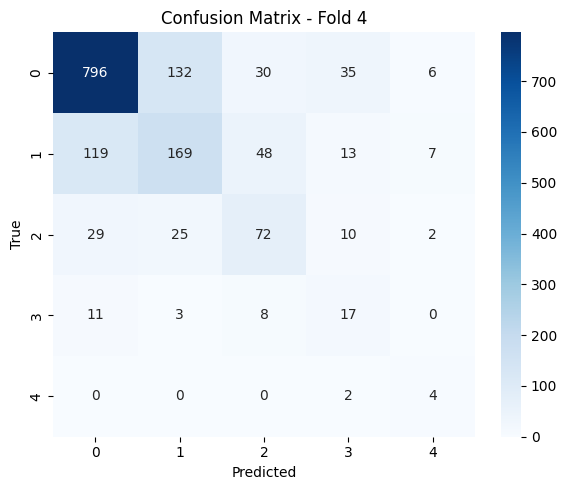

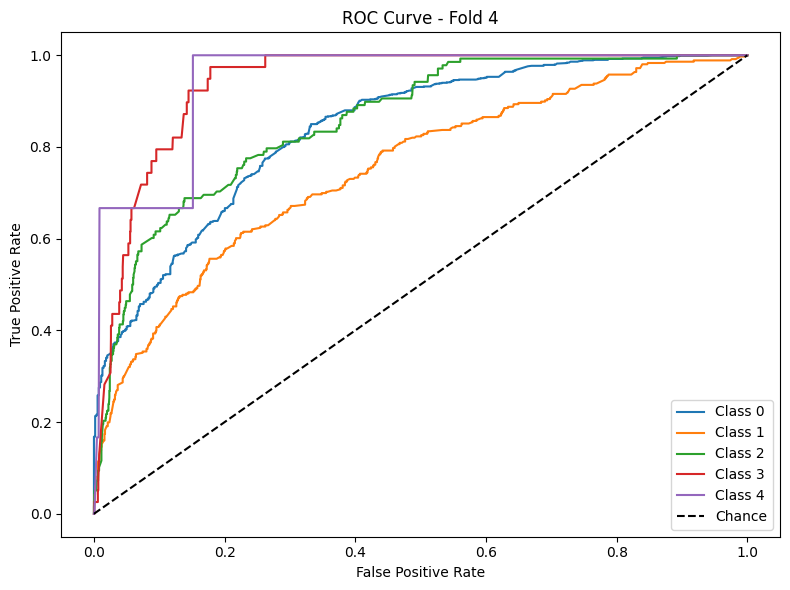


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       999
           1       0.52      0.53      0.53       356
           2       0.39      0.49      0.44       138
           3       0.33      0.54      0.41        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.42      0.47      0.44      1538
weighted avg       0.71      0.69      0.70      1538



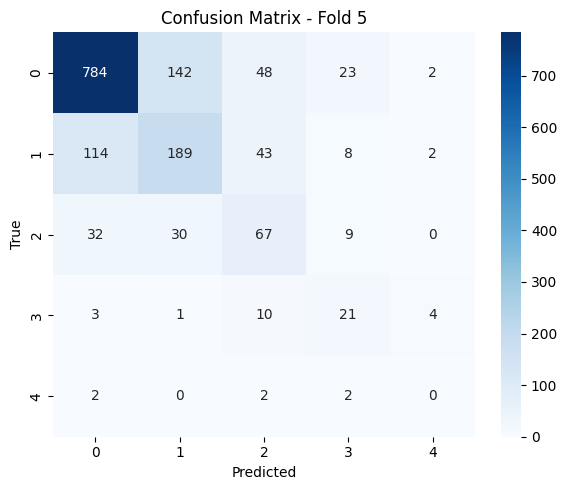

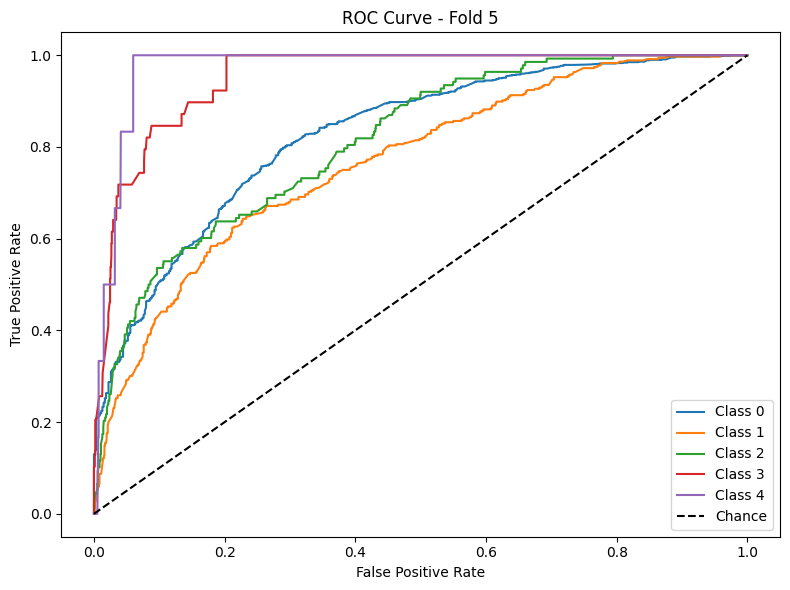


Average Accuracy: 0.6865
Average F1 Macro: 0.4628
Average AUC: 0.8660

Feature Importances:
assignment                             12.172826
remaining_time                         10.722543
school                                  9.700420
exercise_count                          7.235286
video                                   6.897887
chapter_count                           6.499987
user_month                              6.207515
video_count                             5.606347
duration_days                           4.523657
encoded_field_sum                       4.419162
num_prerequisites                       2.893062
total_words_phase1                      2.862068
total_neutral1                          2.023650
total_words_phase4                      1.385563
user_past_course_count                  1.385178
entropy_time_comment_phase4             0.955207
total_neutral4                          0.946593
total_positive4                         0.945590
total_words_phase2       

In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       568
           1       0.29      0.16      0.20        63
           2       0.32      0.19      0.24        43
           3       0.14      0.07      0.09        15
           4       0.00      0.00      0.00         9

    accuracy                           0.80       698
   macro avg       0.32      0.27      0.29       698
weighted avg       0.75      0.80      0.77       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


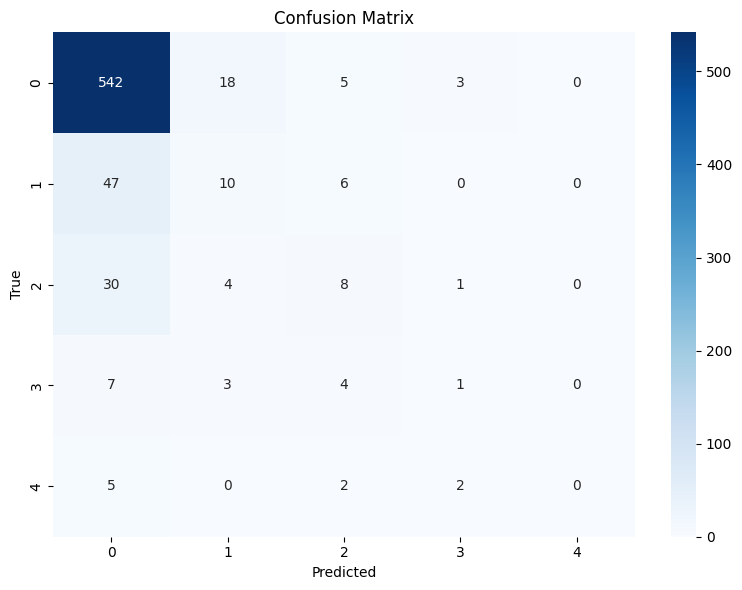


Test AUC (macro-average, OVR): 0.8226


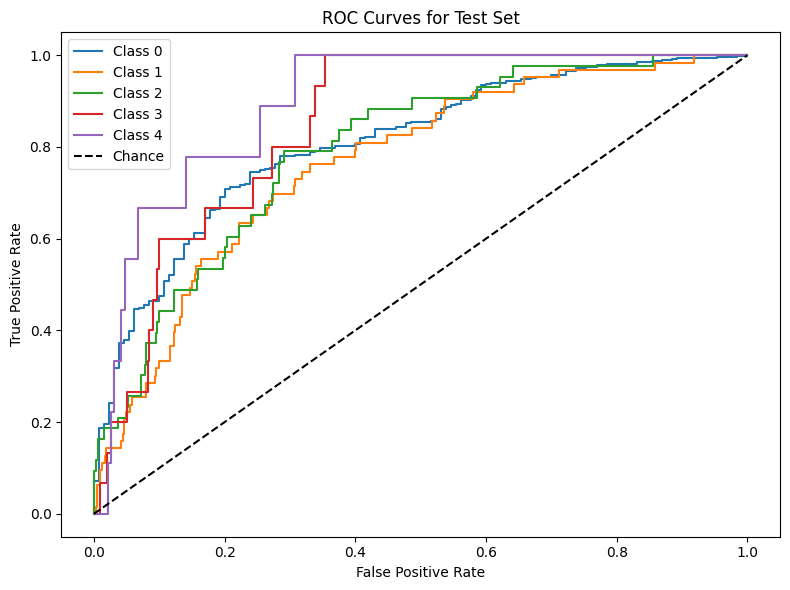


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       544
           1       0.29      0.14      0.18        59
           2       0.44      0.17      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.81       668
   macro avg       0.32      0.25      0.27       668
weighted avg       0.75      0.81      0.77       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


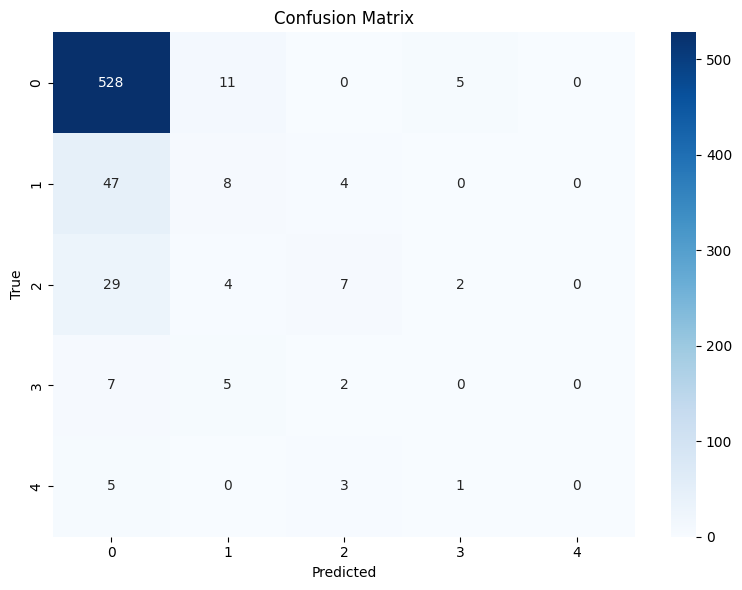


Test AUC (macro-average, OVR): 0.8549


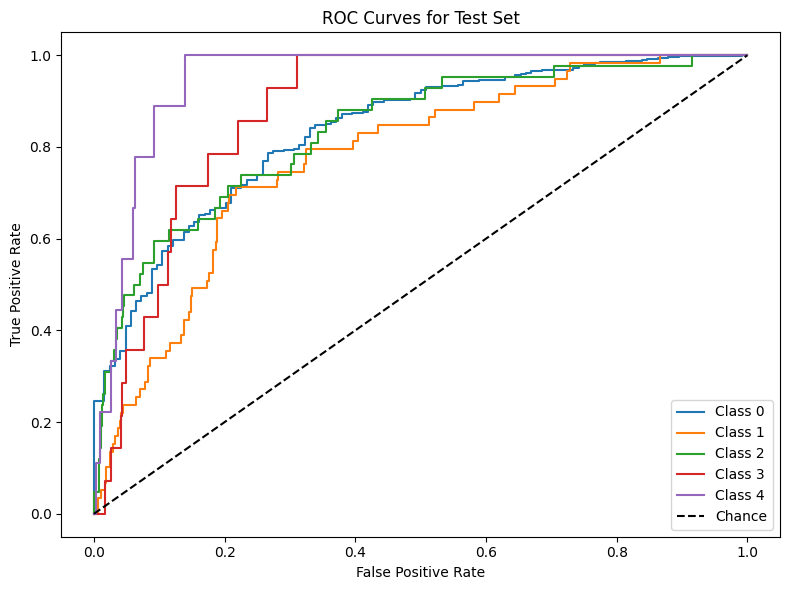


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       455
           1       0.26      0.17      0.21        52
           2       0.17      0.10      0.13        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.78       554
   macro avg       0.26      0.24      0.24       554
weighted avg       0.74      0.78      0.76       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


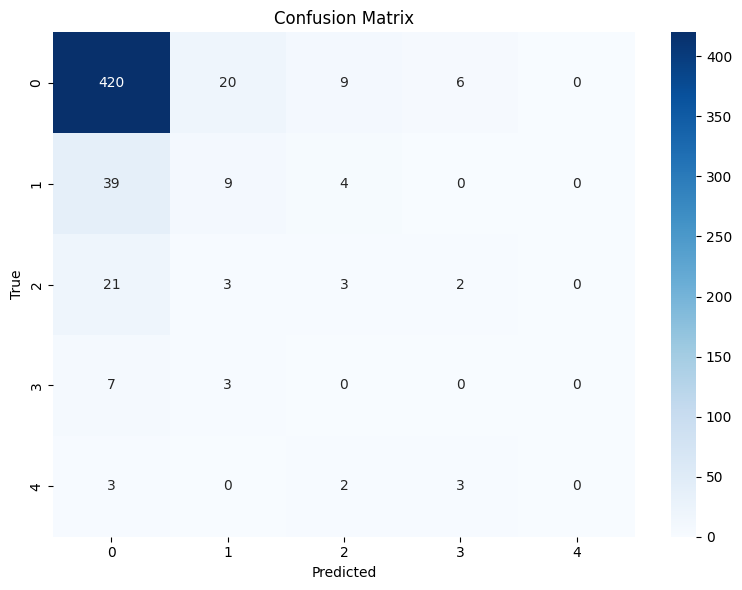


Test AUC (macro-average, OVR): 0.7843


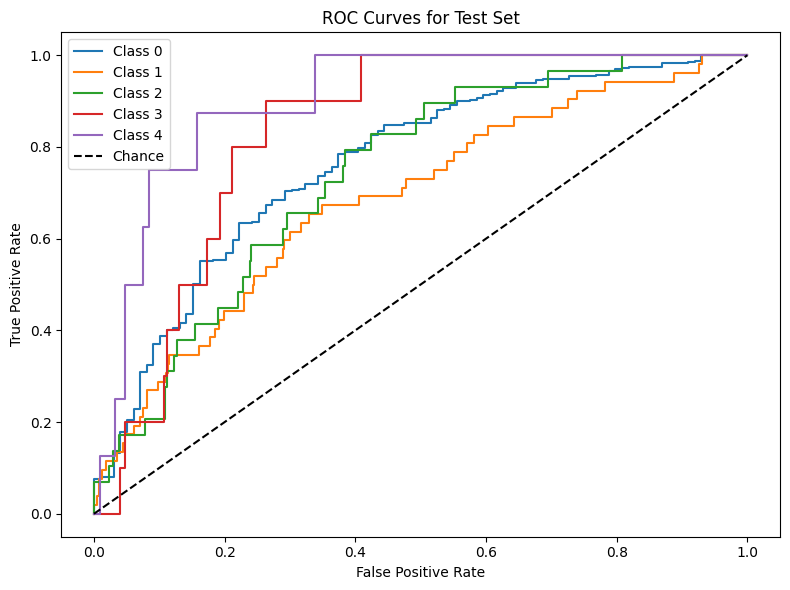


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       395
           1       0.16      0.10      0.12        40
           2       0.18      0.12      0.15        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.80       477
   macro avg       0.24      0.23      0.24       477
weighted avg       0.74      0.80      0.77       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


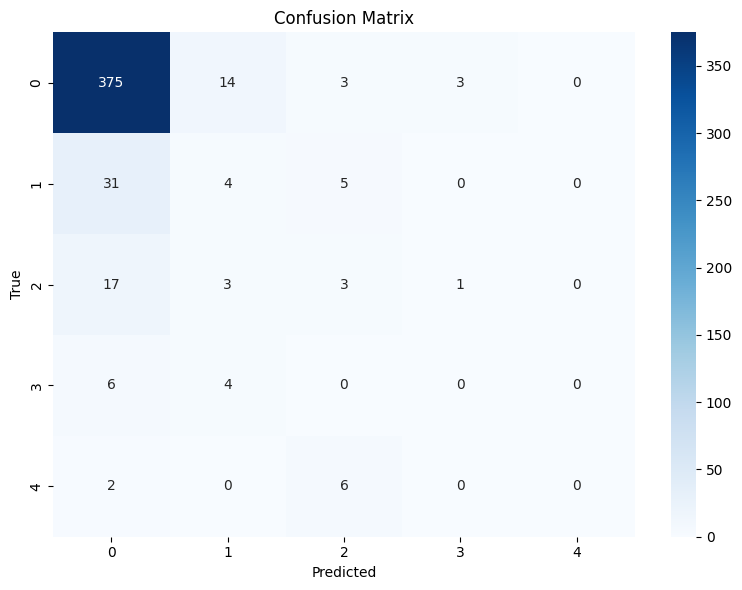


Test AUC (macro-average, OVR): 0.7674


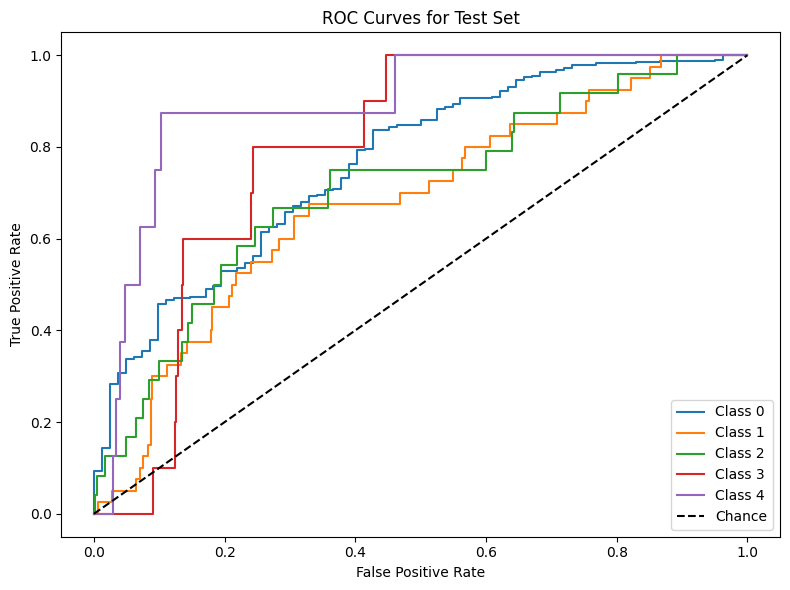

In [9]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)